In [1]:
# Import the libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
from mlxtend.plotting import heatmap
from matplotlib.colors import ListedColormap
sns.set(style="darkgrid")  # default style

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import metrics
from keras import models

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from imblearn.metrics import specificity_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier

import lightgbm as lgb

tf.get_logger().setLevel('INFO')

2024-04-14 21:12:29.749329: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 21:12:29.827683: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 21:12:29.827731: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 21:12:29.827778: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-14 21:12:29.838412: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 21:12:29.839117: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
df = pd.read_csv('./Thyroid_Diff.csv')
df.head(5)

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [3]:
categorical_data = df.select_dtypes(include=['object'])
categorical_columns = categorical_data.columns

In [4]:
#encode for datat after dedupe
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,0,0,0,0,2,3,3,2,1,2,0,0,0,0,2,0
1,34,0,0,1,0,2,1,3,2,1,2,0,0,0,0,1,0
2,30,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
3,62,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
4,62,0,0,0,0,2,1,3,2,0,2,0,0,0,0,1,0


# Data Splitting

Split the data into the following categories:
* All Features
     * Unbalanced
     * Balanced
* ATA Only
     * Unbalanced
     * Balanced
* ATA Excluded
     * Unbalanced
     * Balanced
 

All features includes all 16 features in the model. ATA only includes a single risk factor established in the prognostic guidline established by the American Thyroid Association (ATA). ATA excluded excludes the ATA risk factor and uses the remaining 15 features.

For each category, we also examine training on an unbalanced test set and a balanced training set where oversampling is used to balance the number of recurred and non-recurred.

Let's make some classes to help us transform and split data

In [5]:
class ModelData():
    def __init__(self,X,y):
        # Scale X
        np.random.seed(1234)
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
        # Shuffle values
        indices = np.arange(X.shape[0])
        shuffled_indices = np.random.permutation(indices)
        # print(shuffled_indices)
        X = X[shuffled_indices]
        y = y[shuffled_indices]
        
        # create data splits
        split = (0.6,0.2,0.2)
        split_train, split_val, split_test = split
        num_train = int(X.shape[0] * split_train)
        num_val = int(X.shape[0] * split_val)
            
        X_train = X[:num_train]
        y_train = y[:num_train]
            
        X_val = X[num_train:num_train+num_val+1]
        y_val = y[num_train:num_train+num_val+1]
            
        X_test = X[num_train+num_val+1:]
        y_test = y[num_train+num_val+1:]
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test

    def setX_train(self,X_train):
        self.X_train = X_train

    def sety_train(self,y_train):
        self.y_train = y_train

    def printShapes(self):
        print('Shape of X_train ', self.X_train.shape)
        print('Shape of y_train ', self.y_train.shape)
        
        print('Shape of X_val ', self.X_val.shape)
        print('Shape of y_val ', self.y_val.shape)
        
        print('Shape of X_test ', self.X_test.shape)
        print('Shape of y_test ', self.y_test.shape)

class DataSplit():
    def __init__(self,df,y_label='Recurred'):
        np.random.seed(1234)

        ## All Features
        X = df.iloc[:, df.columns != y_label]
        y = df[y_label]

        self.AllUnbalanced = ModelData(X,y)

        ros = RandomOverSampler(random_state=42)
        self.AllBalanced = ModelData(X,y)
        X_train_b, y_train_b = ros.fit_resample(self.AllBalanced.X_train,self.AllBalanced.y_train)
        self.AllBalanced.setX_train(X_train_b)
        self.AllBalanced.sety_train(y_train_b)

        ## ATA Features
        X_ata = df.iloc[:, df.columns == 'Risk']

        self.AtaUnbalanced = ModelData(X_ata,y)
        ros = RandomOverSampler(random_state=42)
        self.AtaBalanced = ModelData(X_ata,y)
        X_train_c, y_train_c = ros.fit_resample(self.AtaBalanced.X_train,self.AtaBalanced.y_train)
        self.AtaBalanced.setX_train(X_train_c)
        self.AtaBalanced.sety_train(y_train_c)

        ## Excluding ATA Features
        subset_df = df.drop(columns=['Risk'])
        X_no_ata = subset_df.iloc[:,  subset_df.columns != y_label]

        self.NoAtaUnbalanced = ModelData(X_no_ata,y)
        ros = RandomOverSampler(random_state=42)
        self.NoAtaBalanced = ModelData(X,y)
        X_train_d, y_train_d = ros.fit_resample(self.NoAtaBalanced.X_train,self.NoAtaBalanced.y_train)
        self.NoAtaBalanced.setX_train(X_train_d)
        self.NoAtaBalanced.sety_train(y_train_d)

    def printShapes(self):
        print("All Unbalanced:")
        self.AllUnbalanced.printShapes()

        print("\nAll Balanced:")
        self.AllBalanced.printShapes()

        print("\nATA Unbalanced:")
        self.AtaUnbalanced.printShapes()

        print("\nATA Balanced:")
        self.AtaBalanced.printShapes()

        print("\nExcluding ATA Unbalanced:")
        self.NoAtaUnbalanced.printShapes()

        print("\nExcluding ATA Balanced:")
        self.NoAtaBalanced.printShapes()

    def printBalances(self):
        print("All Unbalanced:")
        print('Non-recurred:', self.AllUnbalanced.y_train.value_counts()[0], '/', round(self.AllUnbalanced.y_train.value_counts()[0]/len(self.AllUnbalanced.y_train) * 100,2), '% of the dataset')
        print('Recurred:', self.AllUnbalanced.y_train.value_counts()[1], '/',round(self.AllUnbalanced.y_train.value_counts()[1]/len(self.AllUnbalanced.y_train) * 100,2), '% of the dataset')

        print("\nAll Balanced:")
        print('Non-recurred:', self.AllBalanced.y_train.value_counts()[0], '/', round(self.AllBalanced.y_train.value_counts()[0]/len(self.AllBalanced.y_train) * 100,2), '% of the dataset')
        print('Recurred:', self.AllBalanced.y_train.value_counts()[1], '/',round(self.AllBalanced.y_train.value_counts()[1]/len(self.AllBalanced.y_train) * 100,2), '% of the dataset')

        print("\nATA Unbalanced:")
        print('Non-recurred:', self.AtaUnbalanced.y_train.value_counts()[0], '/', round(self.AtaUnbalanced.y_train.value_counts()[0]/len(self.AtaUnbalanced.y_train) * 100,2), '% of the dataset')
        print('Recurred:', self.AtaUnbalanced.y_train.value_counts()[1], '/',round(self.AtaUnbalanced.y_train.value_counts()[1]/len(self.AtaUnbalanced.y_train) * 100,2), '% of the dataset')

        print("\nATA Balanced:")
        print('Non-recurred:', self.AtaBalanced.y_train.value_counts()[0], '/', round(self.AtaBalanced.y_train.value_counts()[0]/len(self.AtaBalanced.y_train) * 100,2), '% of the dataset')
        print('Recurred:', self.AtaBalanced.y_train.value_counts()[1], '/',round(self.AtaBalanced.y_train.value_counts()[1]/len(self.AtaBalanced.y_train) * 100,2), '% of the dataset')

        print("\nExcluding ATA Unbalanced:")
        print('Non-recurred:', self.NoAtaUnbalanced.y_train.value_counts()[0], '/', round(self.NoAtaUnbalanced.y_train.value_counts()[0]/len(self.NoAtaUnbalanced.y_train) * 100,2), '% of the dataset')
        print('Recurred:', self.NoAtaUnbalanced.y_train.value_counts()[1], '/',round(self.NoAtaUnbalanced.y_train.value_counts()[1]/len(self.NoAtaUnbalanced.y_train) * 100,2), '% of the dataset')

        print("\nExcluding ATA Balanced:")
        print('Non-recurred:', self.NoAtaBalanced.y_train.value_counts()[0], '/', round(self.NoAtaBalanced.y_train.value_counts()[0]/len(self.NoAtaBalanced.y_train) * 100,2), '% of the dataset')
        print('Recurred:', self.NoAtaBalanced.y_train.value_counts()[1], '/',round(self.NoAtaBalanced.y_train.value_counts()[1]/len(self.NoAtaBalanced.y_train) * 100,2), '% of the dataset')

    def getAllUnbalanced(self):
        return self.AllUnbalanced

    def getAllBalanced(self):
        return self.AllBalanced

    def getAtaUnbalanced(self):
        return self.AtaUnbalanced

    def getAtaBalanced(self):
        return self.AtaBalanced

    def getNoAtaUnbalanced(self):
        return self.NoAtaUnbalanced

    def getNoAtaBalanced(self):
        return self.NoAtaBalanced

In [6]:
# DataSplit gives us our 6 different datasets with 60/20/20 splits
ds = DataSplit(df)

In [7]:
# Look at the shapes of the training/validation/test data for each dataset
ds.printShapes()

All Unbalanced:
Shape of X_train  (229, 16)
Shape of y_train  (229,)
Shape of X_val  (77, 16)
Shape of y_val  (77,)
Shape of X_test  (77, 16)
Shape of y_test  (77,)

All Balanced:
Shape of X_train  (326, 16)
Shape of y_train  (326,)
Shape of X_val  (77, 16)
Shape of y_val  (77,)
Shape of X_test  (77, 16)
Shape of y_test  (77,)

ATA Unbalanced:
Shape of X_train  (229, 1)
Shape of y_train  (229,)
Shape of X_val  (77, 1)
Shape of y_val  (77,)
Shape of X_test  (77, 1)
Shape of y_test  (77,)

ATA Balanced:
Shape of X_train  (326, 1)
Shape of y_train  (326,)
Shape of X_val  (77, 1)
Shape of y_val  (77,)
Shape of X_test  (77, 1)
Shape of y_test  (77,)

Excluding ATA Unbalanced:
Shape of X_train  (229, 15)
Shape of y_train  (229,)
Shape of X_val  (77, 15)
Shape of y_val  (77,)
Shape of X_test  (77, 15)
Shape of y_test  (77,)

Excluding ATA Balanced:
Shape of X_train  (326, 16)
Shape of y_train  (326,)
Shape of X_val  (77, 16)
Shape of y_val  (77,)
Shape of X_test  (77, 16)
Shape of y_test  (77

In [8]:
# Look at the ballance for each dataset
ds.printBalances()

All Unbalanced:
Non-recurred: 163 / 71.18 % of the dataset
Recurred: 66 / 28.82 % of the dataset

All Balanced:
Non-recurred: 163 / 50.0 % of the dataset
Recurred: 163 / 50.0 % of the dataset

ATA Unbalanced:
Non-recurred: 163 / 71.18 % of the dataset
Recurred: 66 / 28.82 % of the dataset

ATA Balanced:
Non-recurred: 163 / 50.0 % of the dataset
Recurred: 163 / 50.0 % of the dataset

Excluding ATA Unbalanced:
Non-recurred: 163 / 71.18 % of the dataset
Recurred: 66 / 28.82 % of the dataset

Excluding ATA Balanced:
Non-recurred: 163 / 50.0 % of the dataset
Recurred: 163 / 50.0 % of the dataset


# Models

Now let's write some classes to help us keep track of results from models

In [9]:
class ModelResults():
    def __init__(self,y,y_pred):
        self.y = y
        self.y_pred = y_pred
        # self.accuracy = np.sum(self.y == self.y_pred)/len(self.y)

        self.conf_matrix = confusion_matrix(self.y, self.y_pred)

        self.tn, self.fp, self.fn, self.tp = self.conf_matrix.ravel()

        # Calculate accuracy
        self.accuracy = accuracy_score(y, y_pred)
        
        # Calculate sensitivity (true positive rate)
        self.sensitivity = recall_score(self.y, self.y_pred)
        
        # Calculate specificity (true negative rate)
        self.specificity = specificity_score(self.y, self.y_pred)
        
        # Calculate f1 score
        self.f1 = f1_score(self.y, self.y_pred)

        # Calculate positive predictive value (precision)
        self.ppv = precision_score(self.y, self.y_pred)
        
        # Calculate negative predictive value
        self.npv = self.tn / (self.tn + self.fn)
        
        # Calculate AUC
        self.auc_score = roc_auc_score(self.y, self.y_pred)
        


    def showConfusionMatrix(self, title=''):
        disp = ConfusionMatrixDisplay(confusion_matrix=self.conf_matrix)
        
        # Display confusion matrix
        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(ax=ax)
        plt.title(title)
        plt.show()

    def showResults(self):
        df = pd.DataFrame([self.getResults()])
        display(df)

    def getResults(self):
        return {
            "Sensitivity": self.sensitivity,
            "Specificity": self.specificity,
            "PPV": self.ppv,
            "NPV": self.npv,
            "AUC": self.auc_score,
            "Accuracy": self.accuracy,
            "F1": self.f1,
        }
        
    def showClassificationReport(self):
        print(classification_report(self.y, self.y_pred))

    def showRocCurve(self, title=''):
        plt.figure(figsize = (5, 5))
        fpr, tpr, thresholds = roc_curve(self.y, self.y_pred)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label = "RFC")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()

class ModelAnalysis():
    def __init__(self,data):
        self.data = data
        
    def RandomForest(self,n_estimators=100,max_depth=None,random_state=42,min_samples_leaf=1,min_samples_split=2,class_weight=None):
        # print("\nn_estimators = {}".format(n_estimators))
        # print("max_depth = {}".format(max_depth))
        # print("random_state = {}".format(random_state))
        # print("min_samples_leaf = {}".format(min_samples_leaf))
        # print("min_samples_split = {}".format(min_samples_split))
        # print("class_weight = {}".format(class_weight))
        model = RandomForestClassifier(
            n_estimators=n_estimators, 
            max_depth=max_depth,
            random_state=random_state,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            class_weight=class_weight)
        model.fit(self.data.X_train, self.data.y_train)

        y_val_pred = model.predict(self.data.X_val)
        y_test_pred = model.predict(self.data.X_test)

        return ModelResults(self.data.y_val,y_val_pred), ModelResults(self.data.y_test,y_test_pred)

    def KNN(self,n_neighbors=8, p=2, metric='minkowski', leaf_size = 30):
        model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, metric=metric, leaf_size = leaf_size)
        model.fit(self.data.X_train, self.data.y_train)

        y_val_pred = model.predict(self.data.X_val)
        y_test_pred = model.predict(self.data.X_test)

        return ModelResults(self.data.y_val,y_val_pred), ModelResults(self.data.y_test,y_test_pred)

    def DecisionTree(self,random_state=1234):
        model = DecisionTreeClassifier(random_state=random_state)
        model.fit(self.data.X_train,self.data.y_train)

        y_val_pred = model.predict(self.data.X_val)
        y_test_pred = model.predict(self.data.X_test)

        return ModelResults(self.data.y_val,y_val_pred), ModelResults(self.data.y_test,y_test_pred)

    def SVM(self, kernel='rbf', C=1, gamma='auto', probability=True,random_state=1234, class_weight=None):
        model = SVC(kernel=kernel,C=C,gamma=gamma,probability=probability,random_state=random_state,class_weight=class_weight)
        model.fit(self.data.X_train,self.data.y_train)

        y_val_pred = model.predict(self.data.X_val)
        y_test_pred = model.predict(self.data.X_test)

        return ModelResults(self.data.y_val,y_val_pred), ModelResults(self.data.y_test,y_test_pred)

    def LightGBM(self,learning_rate=0.05, n_estimators=100, num_leaves=31, is_unbalance=True, random_state=1234):
        model = lgb.LGBMClassifier(learning_rate=learning_rate, n_estimators=n_estimators, num_leaves=num_leaves, is_unbalance=is_unbalance,random_state=random_state,verbose=-1)

        model.fit(self.data.X_train,self.data.y_train)

        y_val_pred = model.predict(self.data.X_val)
        y_test_pred = model.predict(self.data.X_test)

        return ModelResults(self.data.y_val,y_val_pred), ModelResults(self.data.y_test,y_test_pred)

    def ANN(self,fileName=''):
        # Model has already been pre-trained, just loading it in here
        model = models.load_model(fileName)
        # model = tf.saved_model.load(fileName)

        # No fitting since model is pretrained
        y_val_pred = model.predict(self.data.X_val)
        y_test_pred = model.predict(self.data.X_test)
        y_val_pred = [1 if k > 0.5 else 0 for k in y_val_pred]
        y_test_pred = [1 if k > 0.5 else 0 for k in y_test_pred]
        # print(y_val_pred)

        return ModelResults(self.data.y_val,y_val_pred), ModelResults(self.data.y_test,y_test_pred)


# Overall Results

Let's compile all of our models and look at a summary of all the results

In [10]:
all_datasets = {
    "All Features": ModelAnalysis(ds.getAllUnbalanced()),
    "All Features Balanced": ModelAnalysis(ds.getAllBalanced()),
    "ATA Features": ModelAnalysis(ds.getAtaUnbalanced()),
    "ATA Features Balanced": ModelAnalysis(ds.getAtaBalanced()),
    "EX ATA Features": ModelAnalysis(ds.getNoAtaUnbalanced()),
    "EX ATA Features Balanced": ModelAnalysis(ds.getNoAtaBalanced())
}

For each datset, call each model and keep track of test results
* Random Forest
* KNN
* DecisionTree
* SVM
* LightGBM
* Artificial Neural Network

In [11]:
# Set hyperparameters for different models/datasets
rf_hp = {
    "All Features": {"n_estimators": 100, "random_state": 42, "class_weight": "balanced"},
    "All Features Balanced": {"n_estimators": 200, "random_state": 42, "min_samples_leaf": 1, "class_weight": "balanced"},
    "ATA Features": {"n_estimators": 250, "max_depth": 8, "random_state": 42, "min_samples_leaf": 2, "class_weight": "balanced"},
    "ATA Features Balanced": {"n_estimators": 250, "max_depth": 5, "random_state": 42, "min_samples_leaf": 1, "min_samples_split": 3},
    "EX ATA Features": {"n_estimators": 250, "max_depth": 7, "random_state": 42, "class_weight": "balanced"},
    "EX ATA Features Balanced": {"n_estimators": 250, "max_depth": 8, "random_state": 42}
}

knn_hp = {
    "All Features": {"n_neighbors": 5, "p": 1, "metric":'minkowski', "leaf_size": 30},
    "All Features Balanced": {"n_neighbors": 5, "p": 1, "metric":'minkowski', "leaf_size": 30},
    "ATA Features": {"n_neighbors": 3, "p": 2, "metric":'minkowski', "leaf_size": 20},
    "ATA Features Balanced": {"n_neighbors": 8, "p": 2, "metric":'minkowski', "leaf_size": 30},
    "EX ATA Features": {"n_neighbors": 5, "p": 2, "metric":'minkowski', "leaf_size": 20},
    "EX ATA Features Balanced": {"n_neighbors": 4, "p": 2, "metric":'minkowski', "leaf_size": 30}
}

dt_hp = {
    "All Features": {"random_state": 1234},
    "All Features Balanced": {"random_state": 1234},
    "ATA Features": {"random_state": 1234},
    "ATA Features Balanced": {"random_state": 1234},
    "EX ATA Features": {"random_state": 1234},
    "EX ATA Features Balanced": {"random_state": 1234}
}

svm_hp = {
    "All Features": {"kernel": 'rbf', "C": 1, "gamma": 'auto', "probability": True},
    "All Features Balanced": {"kernel": 'rbf', "C": 1, "gamma": 'auto', "probability": True},
    "ATA Features": {"kernel": 'linear', "C": 1, "gamma": 'scale', "class_weight": 'balanced', "probability": True},
    "ATA Features Balanced": {"kernel": 'linear', "C": 1, "gamma": 'scale', "class_weight": 'balanced', "probability": True},
    "EX ATA Features": {"kernel": 'rbf', "C": 1, "gamma": 'scale', "probability": True},
    "EX ATA Features Balanced": {"kernel": 'rbf', "C": 1, "gamma": 'scale', "probability": True},
}
    



In [12]:
all_test_results = dict({})
for key,val in all_datasets.items():
    all_test_results["RF " + key] = val.RandomForest(**rf_hp[key])[1]
for key,val in all_datasets.items():
    all_test_results["KNN " + key] = val.KNN(**knn_hp[key])[1]
for key,val in all_datasets.items():
    all_test_results["DT " + key] = val.DecisionTree(**dt_hp[key])[1]
for key,val in all_datasets.items():
    all_test_results["SVM " + key] = val.SVM(**svm_hp[key])[1]
for key,val in all_datasets.items():
    all_test_results["LightGBM " + key] = val.LightGBM()[1]
for key,val in all_datasets.items():
    if key == "All Features":
        all_test_results["ANN " + key] = val.ANN("./BestAnnModel.h5")[1]
    elif key == "All Features Balanced":
        all_test_results["ANN " + key] = val.ANN("./BestAnnModelBalanced.h5")[1]
for key, val in all_datasets.items():
    if key == "All Features":
        all_test_results["ANN Modified " + key] = val.ANN("./BestAnnModifiedModel.h5")[1]
    if key == "All Features Balanced":
        all_test_results["ANN Modified " + key] = val.ANN("./BestAnnModifiedModelBalanced.h5")[1]

3/3 [==============================] - 0s 4ms/step


Look at a summary of the test results

In [13]:
test_results_list = []
for key,val in all_test_results.items():
    test_results_list.append(val.getResults())
summary = pd.DataFrame(test_results_list,index=all_test_results.keys())
summary_percentage = summary.map(lambda x: "{:.2%}".format(x))
summary_percentage

,Sensitivity,Specificity,PPV,NPV,AUC,Accuracy,F1
RF All Features,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%
RF All Features Balanced,100.00%,96.43%,91.30%,100.00%,98.21%,97.40%,95.45%
RF ATA Features,95.24%,82.14%,66.67%,97.87%,88.69%,85.71%,78.43%
RF ATA Features Balanced,95.24%,82.14%,66.67%,97.87%,88.69%,85.71%,78.43%
RF EX ATA Features,100.00%,98.21%,95.45%,100.00%,99.11%,98.70%,97.67%
RF EX ATA Features Balanced,100.00%,96.43%,91.30%,100.00%,98.21%,97.40%,95.45%
KNN All Features,90.48%,96.43%,90.48%,96.43%,93.45%,94.81%,90.48%
KNN All Features Balanced,95.24%,91.07%,80.00%,98.08%,93.15%,92.21%,86.96%
KNN ATA Features,95.24%,82.14%,66.67%,97.87%,88.69%,85.71%,78.43%
KNN ATA Features Balanced,95.24%,82.14%,66.67%,97.87%,88.69%,85.71%,78.43%


## Meta Analysis

In [14]:
# Make the general models features and add data from paper
summary_percentage.loc["Published KNN EX ATA Features"] = {
    "Sensitivity": "80%",
    "Specificity": "98.57%",
    "PPV": "96%",
    "NPV": "92%",
    "AUC": "97.47%",
    "Accuracy": "93%",
    "F1": "NA"
}
summary_percentage.loc["Published KNN ATA Features"] = {
    "Sensitivity": "93.33%",
    "Specificity": "87.14%",
    "PPV": "75.67%",
    "NPV": "96.82%",
    "AUC": "92.59%",
    "Accuracy": "89%",
    "F1": "NA"
}
summary_percentage.loc["Published KNN All Features"] = {
    "Sensitivity": "83%",
    "Specificity": "97.14%",
    "PPV": "92.59%",
    "NPV": "93.15%",
    "AUC": "98.42%",
    "Accuracy": "93%",
    "F1": "NA"
}
summary_percentage.loc["Published SVM EX ATA Features"] = {
    "Sensitivity": "90%",
    "Specificity": "98.57%",
    "PPV": "96.42%",
    "NPV": "94.83%",
    "AUC": "99.23%",
    "Accuracy": "96%",
    "F1": "NA"
}
summary_percentage.loc["Published SVM ATA Features"] = {
    "Sensitivity": "93.33%",
    "Specificity": "87.14%",
    "PPV": "75.67%",
    "NPV": "95.83%",
    "AUC": "92.59%",
    "Accuracy": "89%",
    "F1": "NA"
}
summary_percentage.loc["Published SVM All Features"] = {
    "Sensitivity": "93.33%",
    "Specificity": "97.14%",
    "PPV": "93.33%",
    "NPV": "97.14%",
    "AUC": "99.71%",
    "Accuracy": "96%",
    "F1": "NA"
}
summary_percentage.loc["Published DT EX ATA Features"] = {
    "Sensitivity": "90%",
    "Specificity": "97.14%",
    "PPV": "93%",
    "NPV": "95.77%",
    "AUC": "97.04%",
    "Accuracy": "95%",
    "F1": "NA"
}
summary_percentage.loc["Published DT ATA Features"] = {
    "Sensitivity": "93.33%",
    "Specificity": "87.14%",
    "PPV": "76%",
    "NPV": "96.82%",
    "AUC": "92.59%",
    "Accuracy": "89%",
    "F1": "NA"
}
summary_percentage.loc["Published DT All Features"] = {
    "Sensitivity": "87%",
    "Specificity": "100%",
    "PPV": "100%",
    "NPV": "94.59%",
    "AUC": "99.35%",
    "Accuracy": "96%",
    "F1": "NA"
}
summary_percentage.loc["Published RF EX ATA Features"] = {
    "Sensitivity": "93.33%",
    "Specificity": "97.14%",
    "PPV": "93.33%",
    "NPV": "97.14%",
    "AUC": "98.76%",
    "Accuracy": "96%",
    "F1": "NA"
}
summary_percentage.loc["Published RF ATA Features"] = {
    "Sensitivity": "93.33%",
    "Specificity": "87.14%",
    "PPV": "75.67%",
    "NPV": "96.82%",
    "AUC": "92.59%",
    "Accuracy": "89%",
    "F1": "NA"
}
summary_percentage.loc["Published RF All Features"] = {
    "Sensitivity": "96.66%",
    "Specificity": "94.28%",
    "PPV": "87.87%",
    "NPV": "98.50%",
    "AUC": "99.38%",
    "Accuracy": "95%",
    "F1": "NA"
}
summary_percentage.loc["Published ANN All Features"] = {
    "Sensitivity": "96.6%",
    "Specificity": "95.71%",
    "PPV": "90.6%",
    "NPV": "98.52%",
    "AUC": "99.64%",
    "Accuracy": "96%",
    "F1": "NA"
}
summary_percentage

,Sensitivity,Specificity,PPV,NPV,AUC,Accuracy,F1
RF All Features,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%
RF All Features Balanced,100.00%,96.43%,91.30%,100.00%,98.21%,97.40%,95.45%
RF ATA Features,95.24%,82.14%,66.67%,97.87%,88.69%,85.71%,78.43%
RF ATA Features Balanced,95.24%,82.14%,66.67%,97.87%,88.69%,85.71%,78.43%
RF EX ATA Features,100.00%,98.21%,95.45%,100.00%,99.11%,98.70%,97.67%
RF EX ATA Features Balanced,100.00%,96.43%,91.30%,100.00%,98.21%,97.40%,95.45%
KNN All Features,90.48%,96.43%,90.48%,96.43%,93.45%,94.81%,90.48%
KNN All Features Balanced,95.24%,91.07%,80.00%,98.08%,93.15%,92.21%,86.96%
KNN ATA Features,95.24%,82.14%,66.67%,97.87%,88.69%,85.71%,78.43%
KNN ATA Features Balanced,95.24%,82.14%,66.67%,97.87%,88.69%,85.71%,78.43%


In [15]:
meta_df = pd.DataFrame(summary_percentage)
meta_df.loc[meta_df["F1"] == "NA", "F1"] = 'NaN%'
meta_df = summary_percentage.map(lambda x: float(x.strip('%'))/100.0)
meta_df["Model"] = list(meta_df.index)
meta_df

,Sensitivity,Specificity,PPV,NPV,AUC,Accuracy,F1,Model
RF All Features,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,RF All Features
RF All Features Balanced,1.0000,0.9643,0.9130,1.0000,0.9821,0.9740,0.9545,RF All Features Balanced
RF ATA Features,0.9524,0.8214,0.6667,0.9787,0.8869,0.8571,0.7843,RF ATA Features
RF ATA Features Balanced,0.9524,0.8214,0.6667,0.9787,0.8869,0.8571,0.7843,RF ATA Features Balanced
RF EX ATA Features,1.0000,0.9821,0.9545,1.0000,0.9911,0.9870,0.9767,RF EX ATA Features
RF EX ATA Features Balanced,1.0000,0.9643,0.9130,1.0000,0.9821,0.9740,0.9545,RF EX ATA Features Balanced
KNN All Features,0.9048,0.9643,0.9048,0.9643,0.9345,0.9481,0.9048,KNN All Features
KNN All Features Balanced,0.9524,0.9107,0.8000,0.9808,0.9315,0.9221,0.8696,KNN All Features Balanced
KNN ATA Features,0.9524,0.8214,0.6667,0.9787,0.8869,0.8571,0.7843,KNN ATA Features
KNN ATA Features Balanced,0.9524,0.8214,0.6667,0.9787,0.8869,0.8571,0.7843,KNN ATA Features Balanced


In [16]:
meta_df["Model Type"] = meta_df["Model"].apply(lambda x: "RF" if "RF" in x
                                               else "KNN" if "KNN" in x
                                               else "DT" if "DT" in x
                                               else "SVM" if "SVM" in x
                                               else "LightGBM" if "LightGBM" in x
                                               else "ANN" if "ANN" in x
                                               else x)
meta_df["Published"] = meta_df["Model"].apply(lambda x: 1 if "Published" in x else 0)
meta_df["Balanced"] = meta_df["Model"].apply(lambda x: 1 if "Balanced" in x else 0)
meta_df["Dataset"] = meta_df["Model"].apply(lambda x: "All" if "All" in x else "EX ATA" if "EX ATA" in x else "ATA")
meta_df.index = np.arange(len(list(meta_df.index))).tolist()
meta_df = meta_df.sort_values(["Model Type","Dataset"])
meta_df

,Sensitivity,Specificity,PPV,NPV,AUC,Accuracy,F1,Model,Model Type,Published,Balanced,Dataset
30,0.9048,0.8929,0.7600,0.9615,0.8988,0.8961,0.8261,ANN All Features,ANN,0,0,All
31,0.9048,0.9107,0.7917,0.9623,0.9077,0.9091,0.8444,ANN All Features Balanced,ANN,0,1,All
32,0.9524,0.9107,0.8000,0.9808,0.9315,0.9221,0.8696,ANN Modified All Features,ANN,0,0,All
33,0.8571,0.8393,0.6667,0.9400,0.8482,0.8442,0.7500,ANN Modified All Features Balanced,ANN,0,1,All
46,0.9660,0.9571,0.9060,0.9852,0.9964,0.9600,NaN,Published ANN All Features,ANN,1,0,All
14,0.9524,0.8214,0.6667,0.9787,0.8869,0.8571,0.7843,DT ATA Features,DT,0,0,ATA
15,0.9524,0.8214,0.6667,0.9787,0.8869,0.8571,0.7843,DT ATA Features Balanced,DT,0,1,ATA
41,0.9333,0.8714,0.7600,0.9682,0.9259,0.8900,NaN,Published DT ATA Features,DT,1,0,ATA
12,0.8095,0.9643,0.8947,0.9310,0.8869,0.9221,0.8500,DT All Features,DT,0,0,All
13,0.9048,0.9107,0.7917,0.9623,0.9077,0.9091,0.8444,DT All Features Balanced,DT,0,1,All


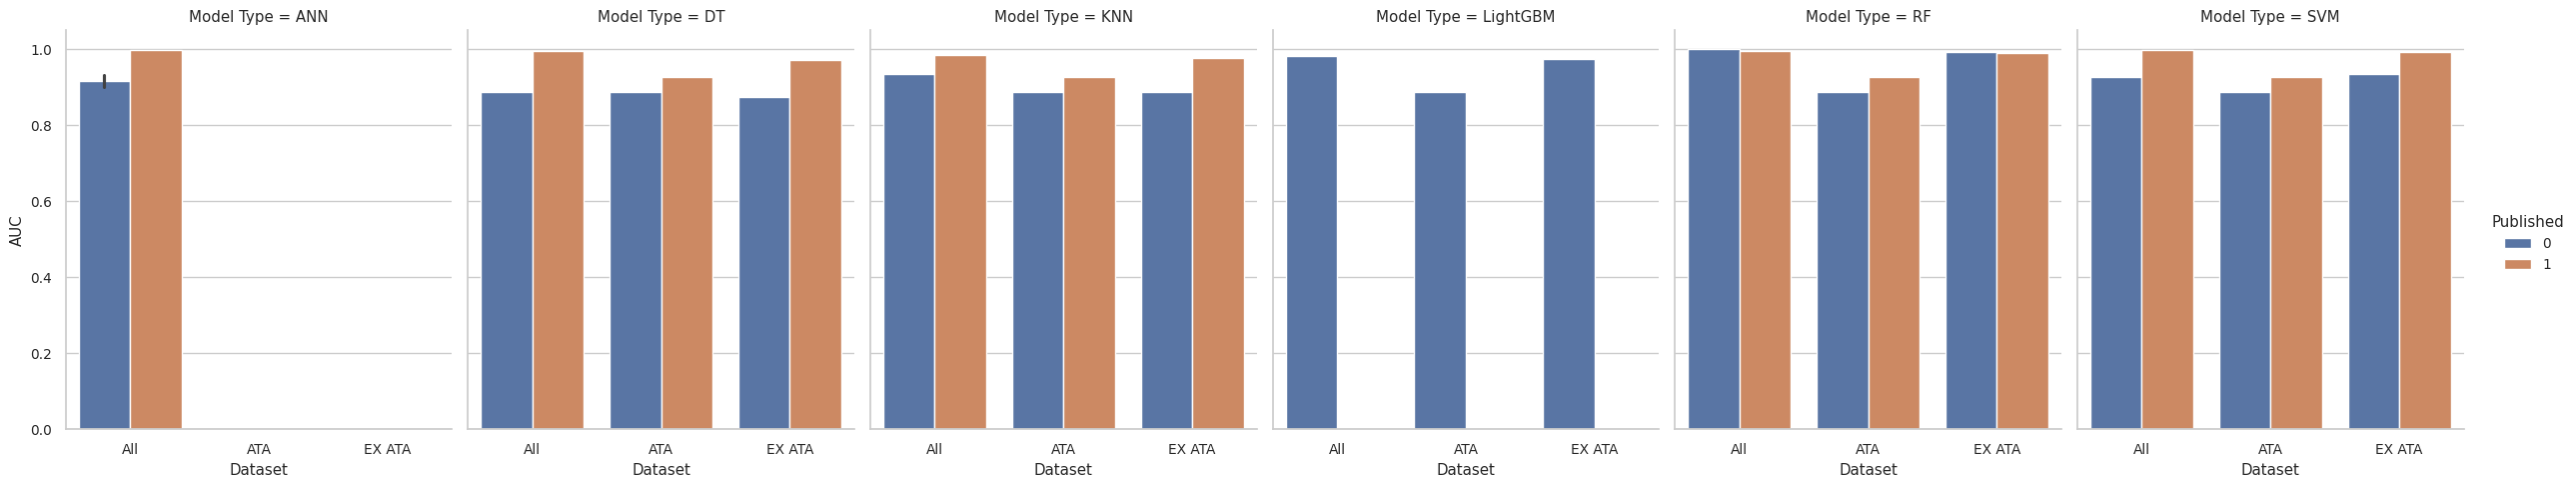

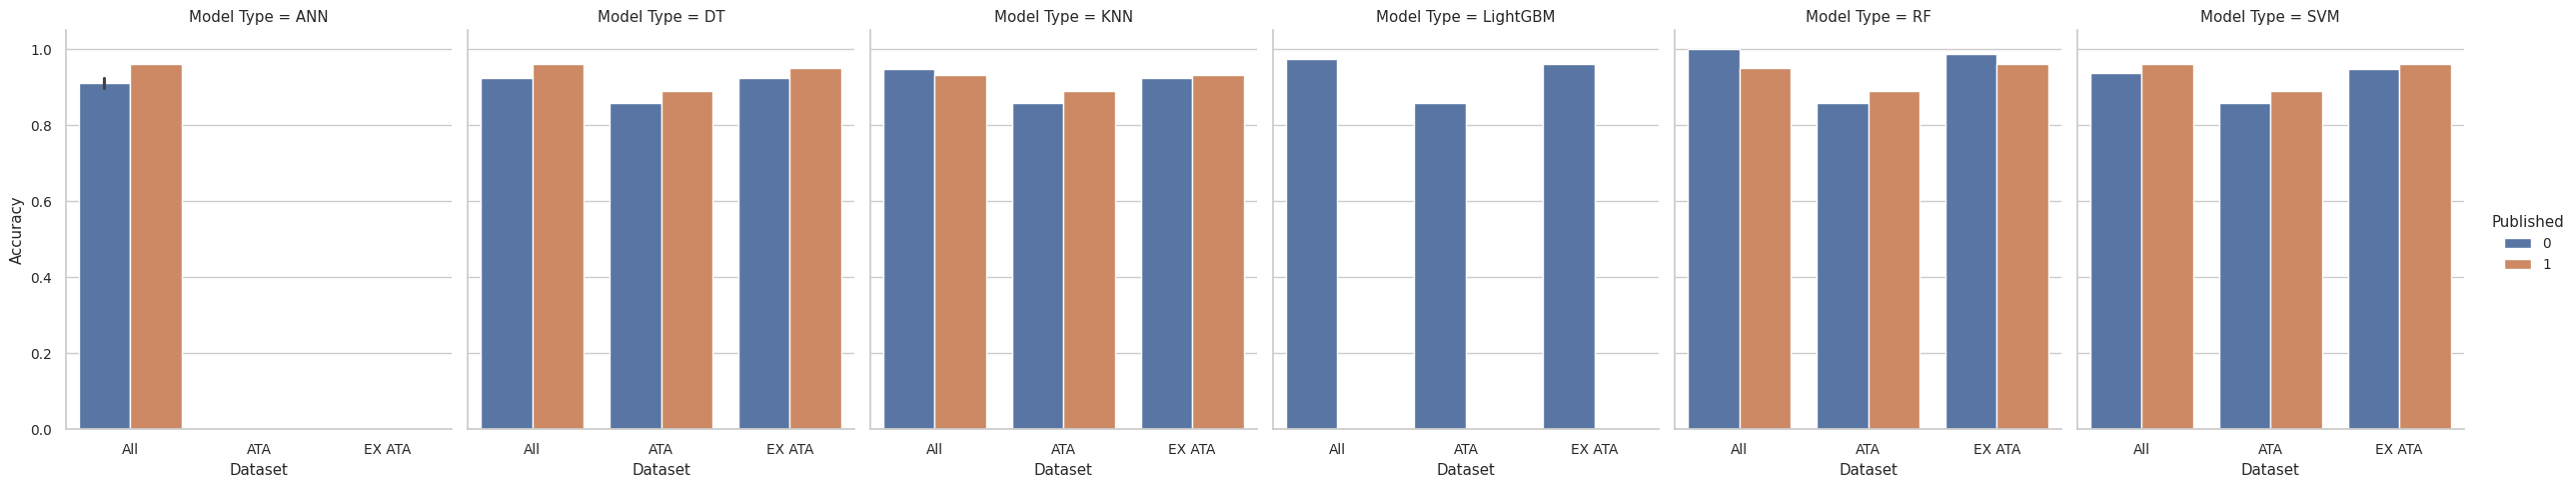

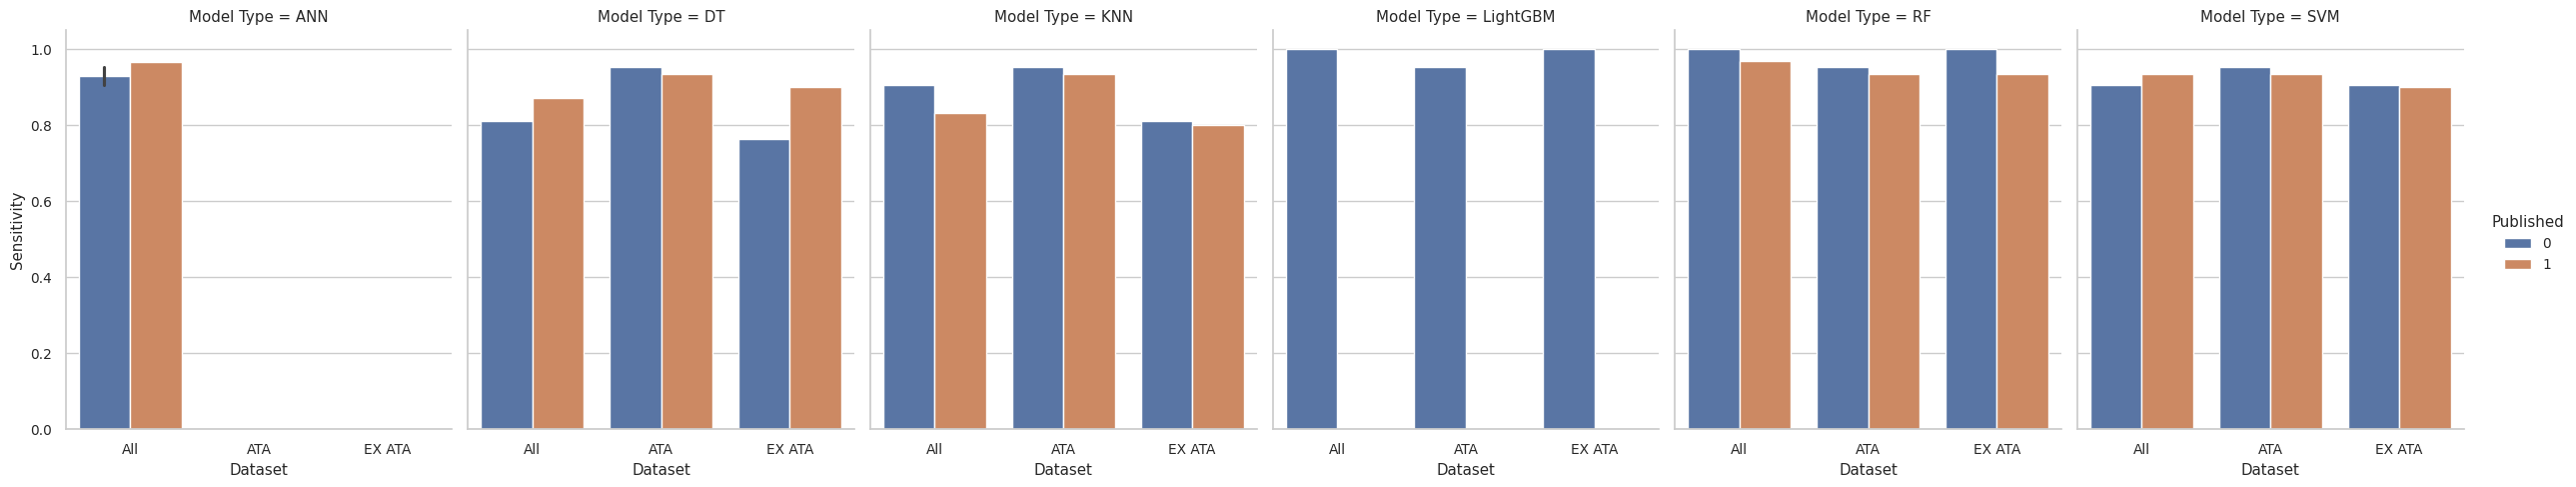

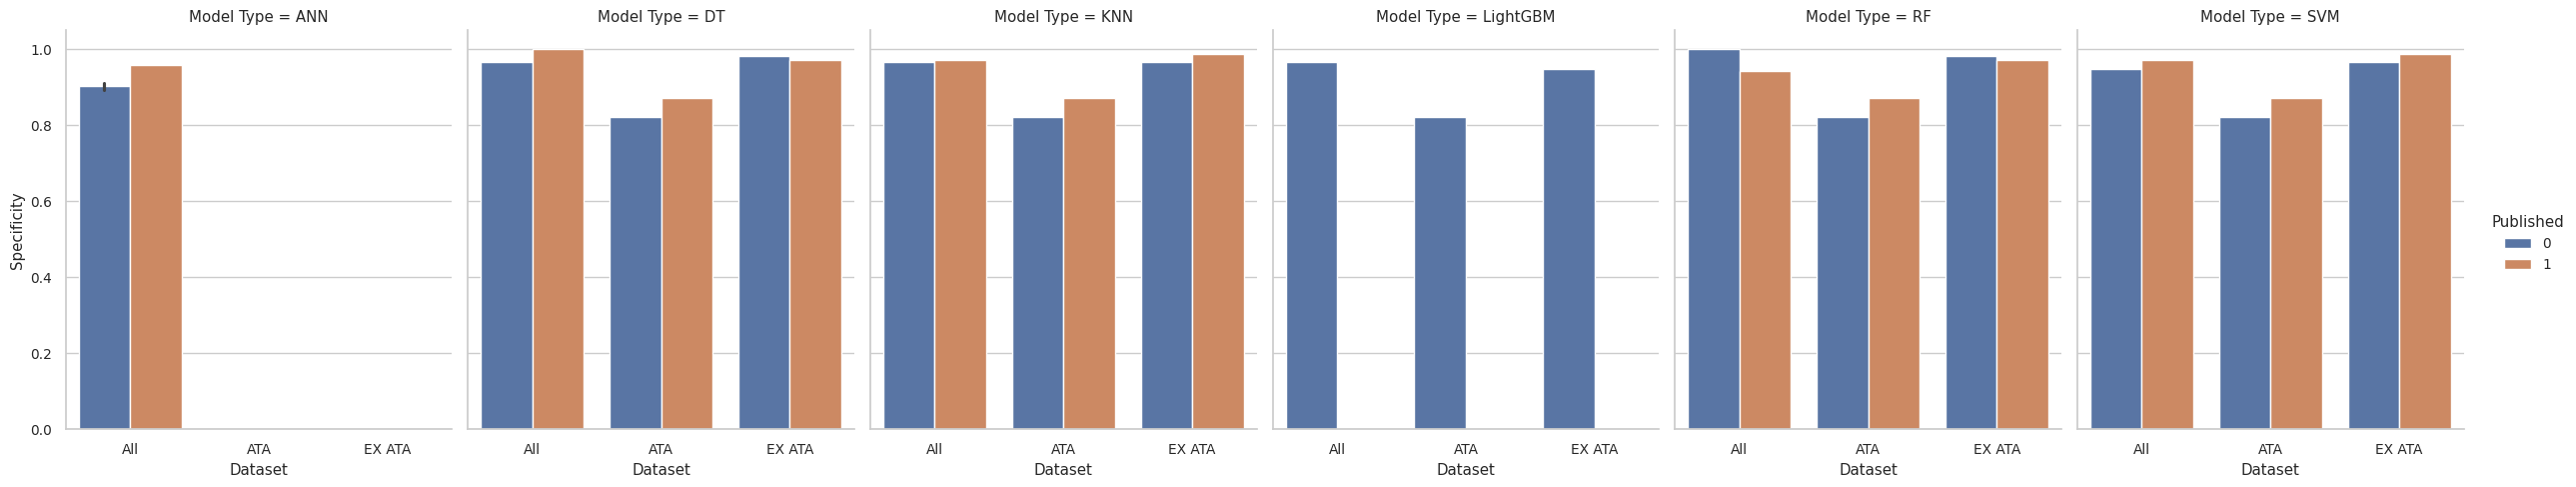

In [17]:
sns.set_theme(style="whitegrid",font_scale=0.9)
p = sns.catplot(
    meta_df.loc[meta_df["Balanced"] == 0],
    kind="bar",
    x="Dataset", 
    y="AUC", 
    hue="Published",
    col="Model Type", 
    height=5, 
    aspect=5/6.0,
)
plt.savefig("Published-vs-Our-Results-AUC.png")
p = sns.catplot(
    meta_df.loc[meta_df["Balanced"] == 0],
    kind="bar",
    x="Dataset", 
    y="Accuracy", 
    hue="Published",
    col="Model Type", 
    height=5, 
    aspect=5/6.0,
)
plt.savefig("Published-vs-Our-Results-Accuracy.png")
p = sns.catplot(
    meta_df.loc[meta_df["Balanced"] == 0],
    kind="bar",
    x="Dataset", 
    y="Sensitivity", 
    hue="Published",
    col="Model Type", 
    height=5, 
    aspect=5/6.0,
)
plt.savefig("Published-vs-Our-Results-Sensitivity.png")
p = sns.catplot(
    meta_df.loc[meta_df["Balanced"] == 0],
    kind="bar",
    x="Dataset", 
    y="Specificity", 
    hue="Published",
    col="Model Type", 
    height=5, 
    aspect=5/6.0,
)
plt.savefig("Published-vs-Our-Results-Specificity.png")



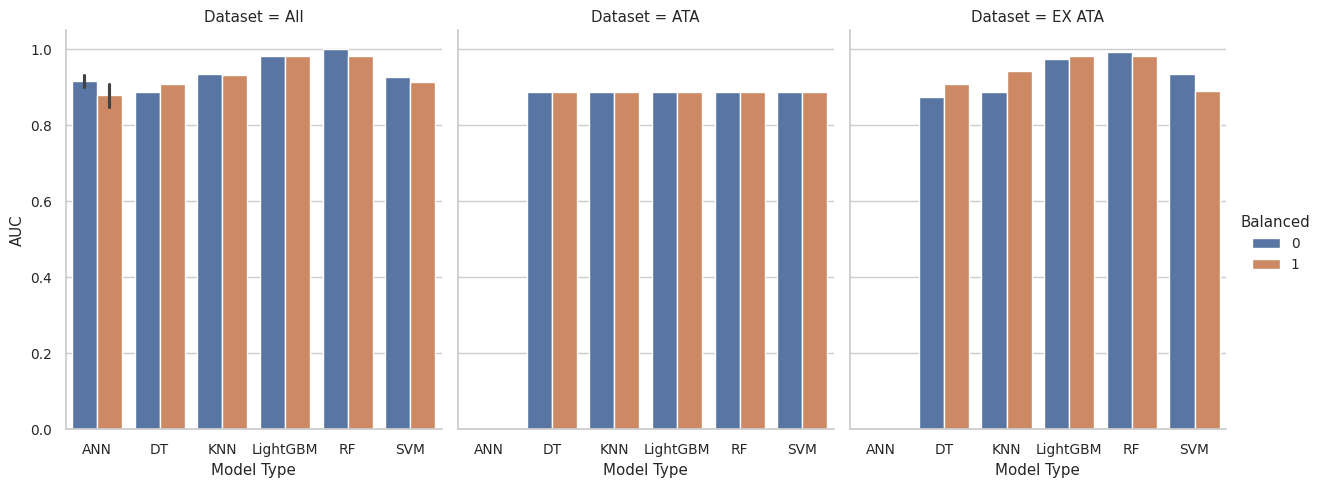

In [18]:
p = sns.catplot(
    meta_df.loc[meta_df["Published"] == 0],
    kind="bar",
    x="Model Type", 
    y="AUC", 
    hue="Balanced",
    col="Dataset", 
    height=5, 
    aspect=5/6.0,
)
plt.savefig("Balanced-vs-Unbalanced.png")

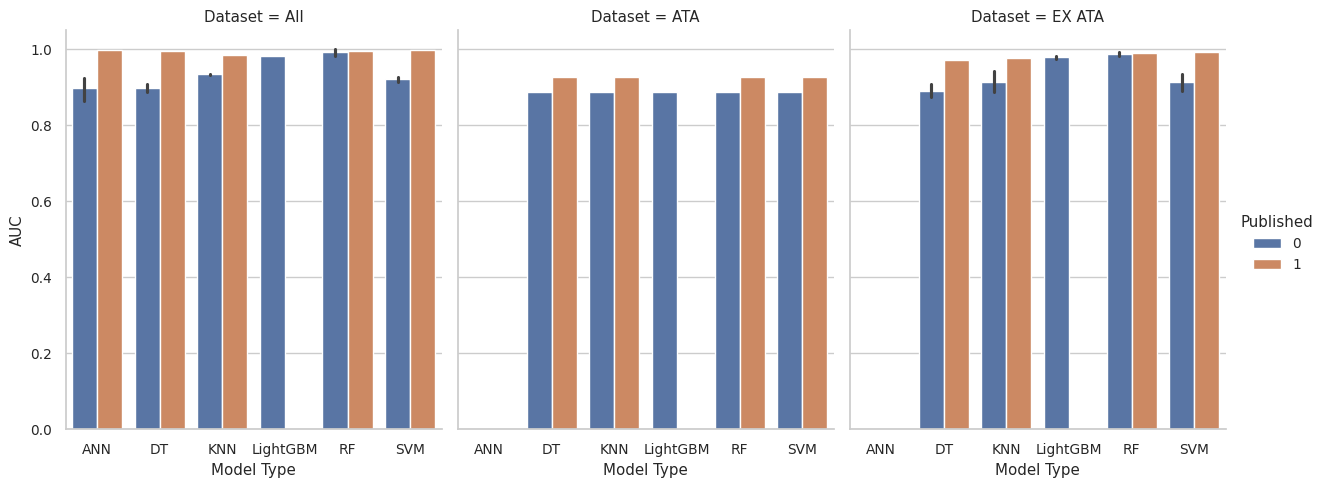

In [19]:
p = sns.catplot(
    meta_df,
    kind="bar",
    x="Model Type", 
    y="AUC", 
    hue="Published",
    col="Dataset",
    height=5, 
    aspect=5/6.0,
)
plt.savefig("Dataset-Comparison.png")

LightGBM Results

In [21]:
summary_percentage["AUC"] = summary_percentage["AUC"].apply(lambda x: float(x.strip("%"))/100.0)

In [22]:
lightGbmSummary = summary_percentage.loc[[
    "LightGBM All Features", 
     "LightGBM All Features Balanced",
     "LightGBM ATA Features",
     "LightGBM ATA Features Balanced",
     "LightGBM EX ATA Features",
     "LightGBM EX ATA Features Balanced",
    ]]
lightGbmSummary

,Sensitivity,Specificity,PPV,NPV,AUC,Accuracy,F1
LightGBM All Features,100.00%,96.43%,91.30%,100.00%,0.9821,97.40%,95.45%
LightGBM All Features Balanced,100.00%,96.43%,91.30%,100.00%,0.9821,97.40%,95.45%
LightGBM ATA Features,95.24%,82.14%,66.67%,97.87%,0.8869,85.71%,78.43%
LightGBM ATA Features Balanced,95.24%,82.14%,66.67%,97.87%,0.8869,85.71%,78.43%
LightGBM EX ATA Features,100.00%,94.64%,87.50%,100.00%,0.9732,96.10%,93.33%
LightGBM EX ATA Features Balanced,100.00%,96.43%,91.30%,100.00%,0.9821,97.40%,95.45%


ANN Results

In [24]:
annSummary = summary_percentage.loc[[
     "ANN All Features", 
     "ANN All Features Balanced",
     "ANN Modified All Features",
     "ANN Modified All Features Balanced",
    ]]
# Add values form paper
annSummary.loc["Published ANN All Features"] = {
    "Sensitivity": "96.6%",
    "Specificity": "95.71%",
    "PPV": "90.6%",
    "NPV": "98.52%",
    "AUC": "0.9964",
    "Accuracy": "96%",
    "F1": "NA"
}
annSummary

,Sensitivity,Specificity,PPV,NPV,AUC,Accuracy,F1
ANN All Features,90.48%,89.29%,76.00%,96.15%,0.8988,89.61%,82.61%
ANN All Features Balanced,90.48%,91.07%,79.17%,96.23%,0.9077,90.91%,84.44%
ANN Modified All Features,95.24%,91.07%,80.00%,98.08%,0.9315,92.21%,86.96%
ANN Modified All Features Balanced,85.71%,83.93%,66.67%,94.00%,0.8482,84.42%,75.00%
Published ANN All Features,96.6%,95.71%,90.6%,98.52%,0.9964,96%,NA


# Detailed Results

## Random Forest

### All Features (Unbalanced)

In [13]:
ma = ModelAnalysis(ds.getAllUnbalanced())
val_res, test_res = ma.RandomForest()

In [14]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.904762,0.982143,0.95,0.964912,0.943452,0.961039,0.926829


In [15]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


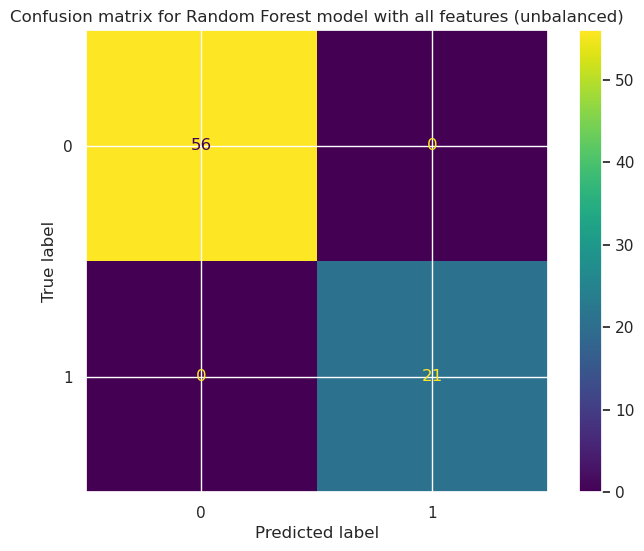

In [16]:
test_res.showConfusionMatrix('Confusion matrix for Random Forest model with all features (unbalanced)')

In [17]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        21

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77



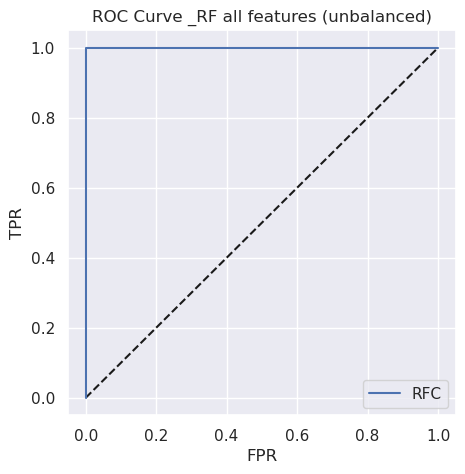

In [18]:
test_res.showRocCurve('ROC Curve _RF all features (unbalanced)')

### All Features (Balanced)

In [19]:
ma = ModelAnalysis(ds.getAllBalanced())
val_res, test_res = ma.RandomForest()

In [20]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.916667,0.981132,0.956522,0.962963,0.948899,0.961039,0.93617


In [21]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.916667,1.0,1.0,0.963636,0.958333,0.974026,0.956522


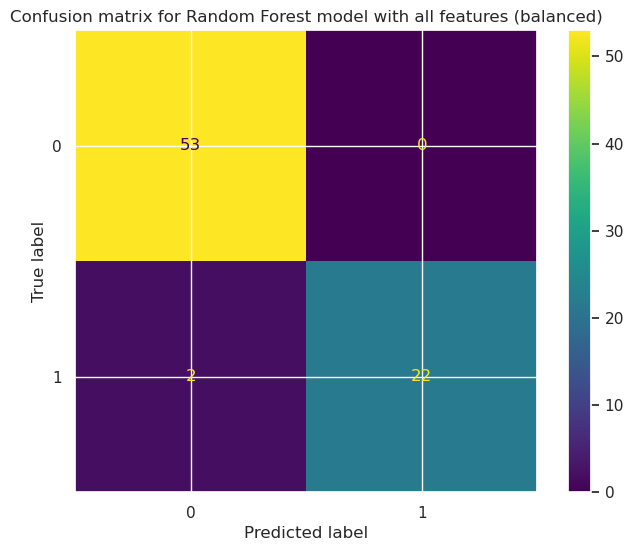

In [22]:
test_res.showConfusionMatrix('Confusion matrix for Random Forest model with all features (balanced)')

In [23]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        53
           1       1.00      0.92      0.96        24

    accuracy                           0.97        77
   macro avg       0.98      0.96      0.97        77
weighted avg       0.97      0.97      0.97        77



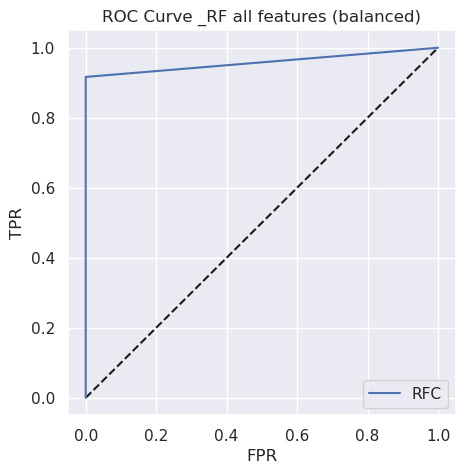

In [24]:
test_res.showRocCurve('ROC Curve _RF all features (balanced)')

### ATA Features (Unbalanced)

In [25]:
ma = ModelAnalysis(ds.getAtaUnbalanced())
val_res, test_res = ma.RandomForest()

In [26]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.944444,0.830508,0.62963,0.98,0.887476,0.857143,0.755556


In [27]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.875,0.885246,0.666667,0.964286,0.880123,0.883117,0.756757


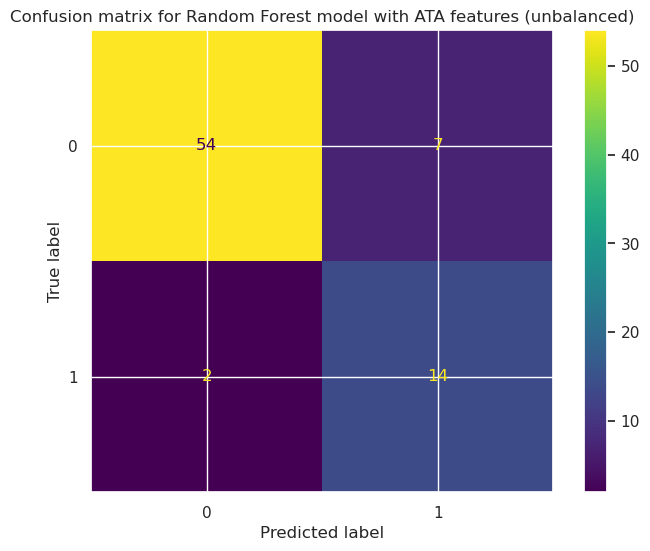

In [28]:
test_res.showConfusionMatrix('Confusion matrix for Random Forest model with ATA features (unbalanced)')

In [29]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.96      0.89      0.92        61
           1       0.67      0.88      0.76        16

    accuracy                           0.88        77
   macro avg       0.82      0.88      0.84        77
weighted avg       0.90      0.88      0.89        77



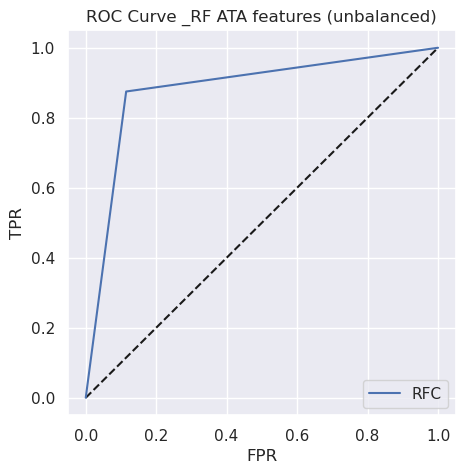

In [30]:
test_res.showRocCurve('ROC Curve _RF ATA features (unbalanced)')

### ATA Features (Balanced)

In [31]:
ma = ModelAnalysis(ds.getAtaBalanced())
val_res, test_res = ma.RandomForest()

In [32]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.8,0.884615,0.769231,0.901961,0.842308,0.857143,0.784314


In [33]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.954545,0.8,0.65625,0.977778,0.877273,0.844156,0.777778


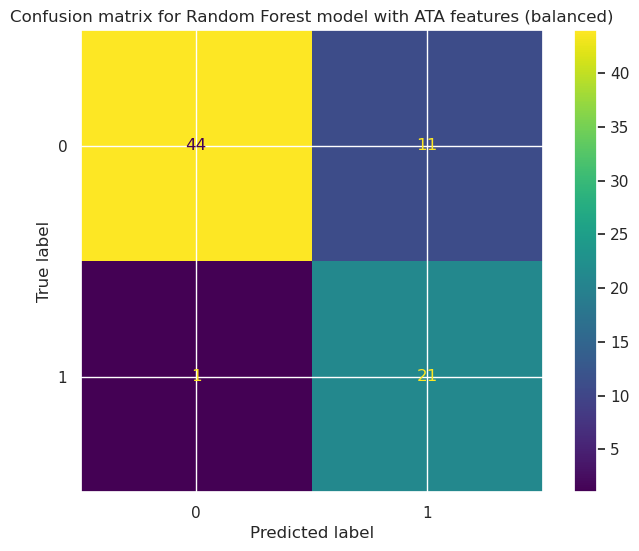

In [34]:
test_res.showConfusionMatrix('Confusion matrix for Random Forest model with ATA features (balanced)')

In [35]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.98      0.80      0.88        55
           1       0.66      0.95      0.78        22

    accuracy                           0.84        77
   macro avg       0.82      0.88      0.83        77
weighted avg       0.89      0.84      0.85        77



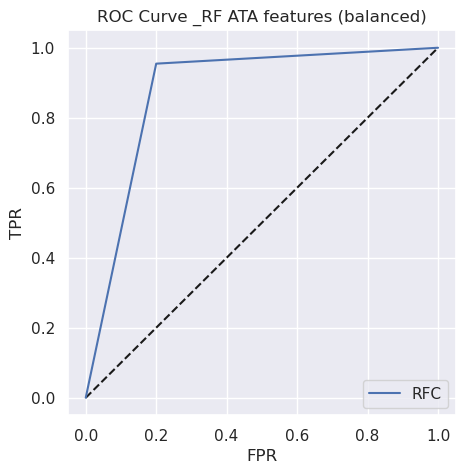

In [36]:
test_res.showRocCurve('ROC Curve _RF ATA features (balanced)')

### Excluding ATA Features (Unbalanced)

In [37]:
ma = ModelAnalysis(ds.getNoAtaUnbalanced())
val_res, test_res = ma.RandomForest()

In [38]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.842105,0.965517,0.888889,0.949153,0.903811,0.935065,0.864865


In [39]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.916667,0.981132,0.956522,0.962963,0.948899,0.961039,0.93617


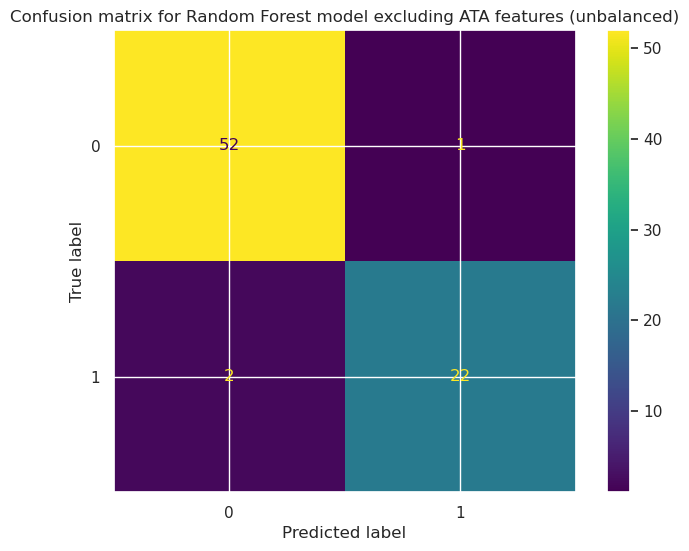

In [40]:
test_res.showConfusionMatrix('Confusion matrix for Random Forest model excluding ATA features (unbalanced)')

In [41]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        53
           1       0.96      0.92      0.94        24

    accuracy                           0.96        77
   macro avg       0.96      0.95      0.95        77
weighted avg       0.96      0.96      0.96        77



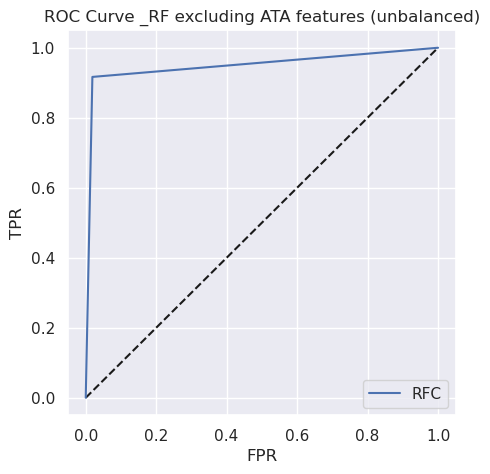

In [42]:
test_res.showRocCurve('ROC Curve _RF excluding ATA features (unbalanced)')

### Excluding ATA Features (Balanced)

In [43]:
ma = ModelAnalysis(ds.getNoAtaBalanced())
val_res, test_res = ma.RandomForest()

In [44]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.92,0.961538,0.92,0.961538,0.940769,0.948052,0.92


In [45]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.809524,0.964286,0.894737,0.931034,0.886905,0.922078,0.85


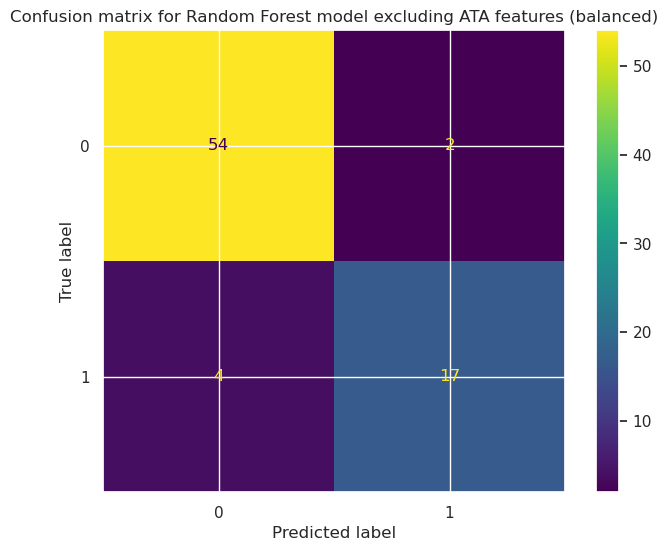

In [46]:
test_res.showConfusionMatrix('Confusion matrix for Random Forest model excluding ATA features (balanced)')

In [47]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        56
           1       0.89      0.81      0.85        21

    accuracy                           0.92        77
   macro avg       0.91      0.89      0.90        77
weighted avg       0.92      0.92      0.92        77



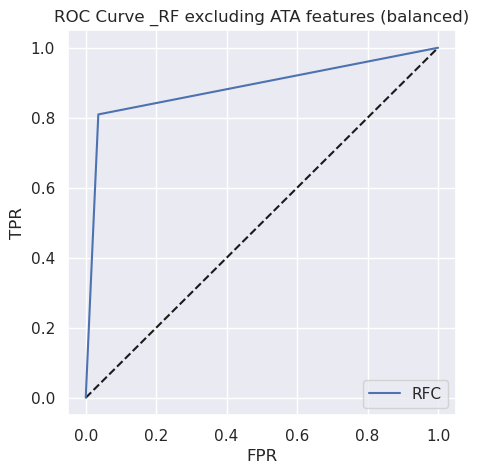

In [48]:
test_res.showRocCurve('ROC Curve _RF excluding ATA features (balanced)')

## KNN

### All Features (Unbalanced)

In [49]:
ma = ModelAnalysis(ds.getAllUnbalanced())
val_res, test_res = ma.KNN()

In [50]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.714286,0.982143,0.9375,0.901639,0.848214,0.909091,0.810811


In [51]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.714286,0.982143,0.9375,0.901639,0.848214,0.909091,0.810811


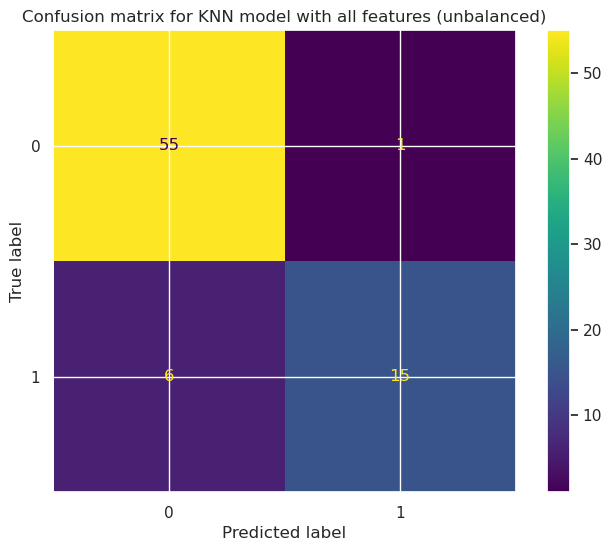

In [52]:
test_res.showConfusionMatrix('Confusion matrix for KNN model with all features (unbalanced)')

In [53]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.90      0.98      0.94        56
           1       0.94      0.71      0.81        21

    accuracy                           0.91        77
   macro avg       0.92      0.85      0.88        77
weighted avg       0.91      0.91      0.90        77



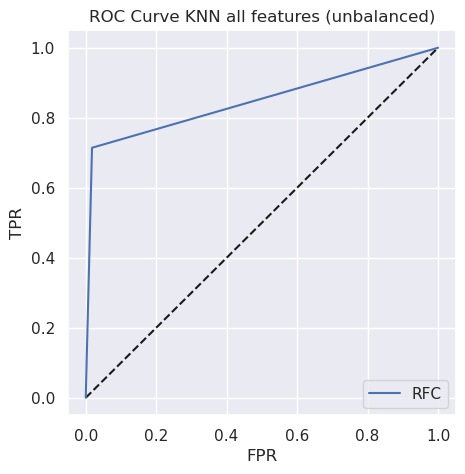

In [54]:
test_res.showRocCurve('ROC Curve KNN all features (unbalanced)')

### All Features (Balanced)

In [55]:
ma = ModelAnalysis(ds.getAllBalanced())
val_res, test_res = ma.KNN()

In [56]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.75,0.924528,0.818182,0.890909,0.837264,0.87013,0.782609


In [57]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.791667,0.924528,0.826087,0.907407,0.858097,0.883117,0.808511


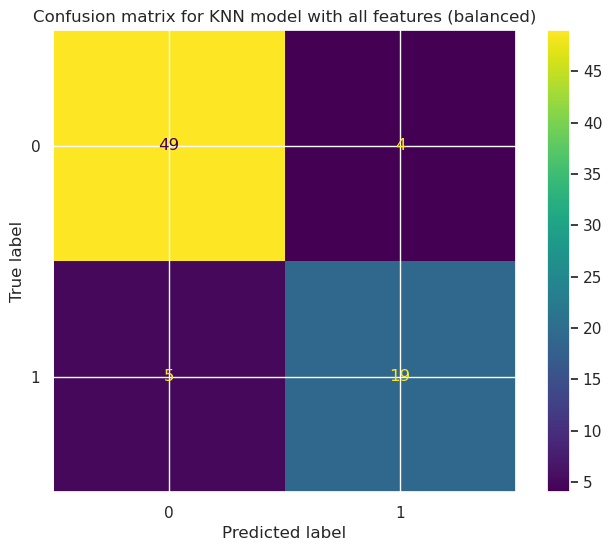

In [58]:
test_res.showConfusionMatrix('Confusion matrix for KNN model with all features (balanced)')

In [59]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.91      0.92      0.92        53
           1       0.83      0.79      0.81        24

    accuracy                           0.88        77
   macro avg       0.87      0.86      0.86        77
weighted avg       0.88      0.88      0.88        77



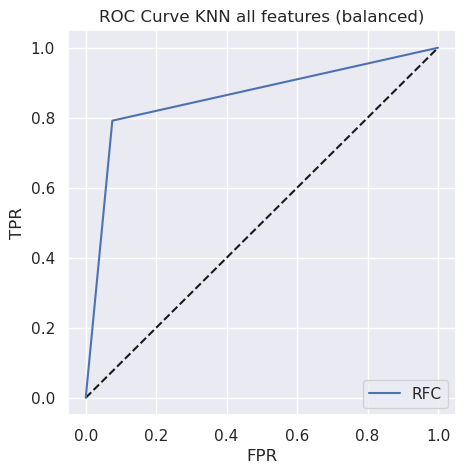

In [60]:
test_res.showRocCurve('ROC Curve KNN all features (balanced)')

### ATA Features (Unbalanced)

In [61]:
ma = ModelAnalysis(ds.getAtaUnbalanced())
val_res, test_res = ma.KNN()

In [62]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.944444,0.830508,0.62963,0.98,0.887476,0.857143,0.755556


In [63]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.875,0.885246,0.666667,0.964286,0.880123,0.883117,0.756757


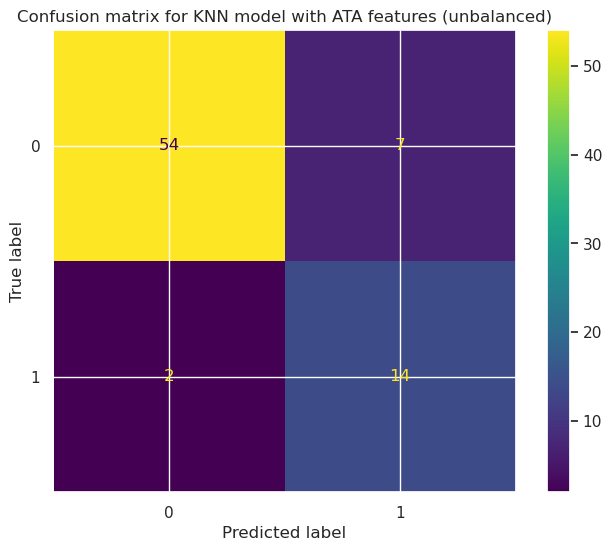

In [64]:
test_res.showConfusionMatrix('Confusion matrix for KNN model with ATA features (unbalanced)')

In [65]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.96      0.89      0.92        61
           1       0.67      0.88      0.76        16

    accuracy                           0.88        77
   macro avg       0.82      0.88      0.84        77
weighted avg       0.90      0.88      0.89        77



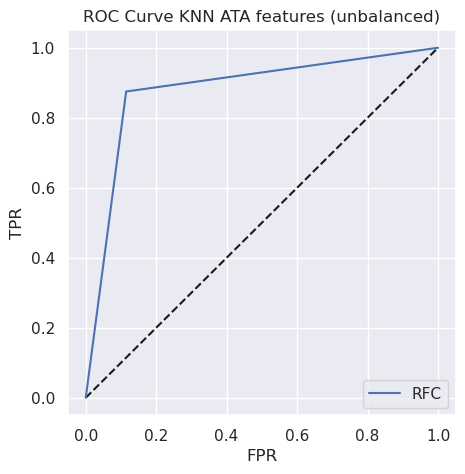

In [66]:
test_res.showRocCurve('ROC Curve KNN ATA features (unbalanced)')

### ATA Features (Balanced)

In [67]:
ma = ModelAnalysis(ds.getAtaBalanced())
val_res, test_res = ma.KNN()

In [68]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.8,0.884615,0.769231,0.901961,0.842308,0.857143,0.784314


In [69]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.954545,0.8,0.65625,0.977778,0.877273,0.844156,0.777778


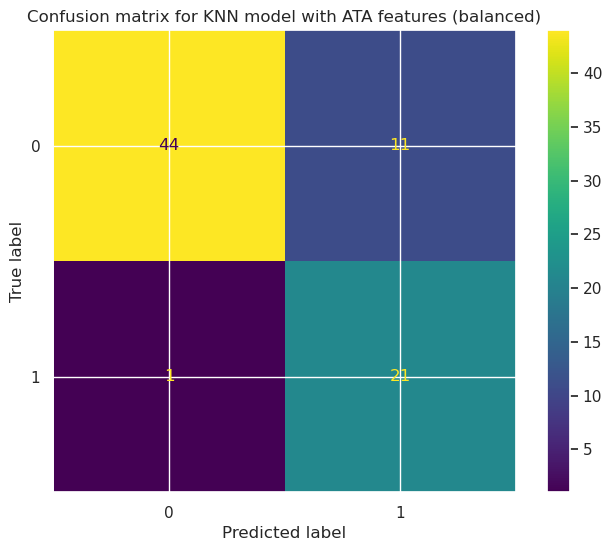

In [70]:
test_res.showConfusionMatrix('Confusion matrix for KNN model with ATA features (balanced)')

In [71]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.98      0.80      0.88        55
           1       0.66      0.95      0.78        22

    accuracy                           0.84        77
   macro avg       0.82      0.88      0.83        77
weighted avg       0.89      0.84      0.85        77



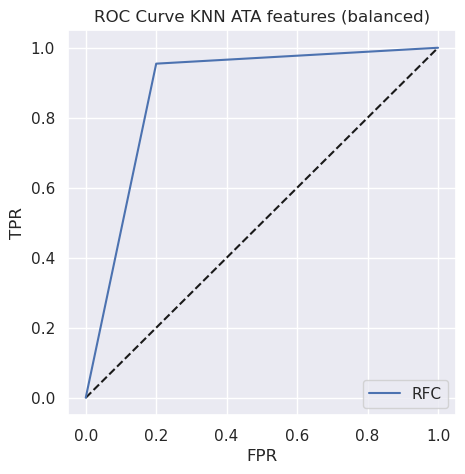

In [72]:
test_res.showRocCurve('ROC Curve KNN ATA features (balanced)')

### Excluding ATA Features (Unbalanced)

In [73]:
ma = ModelAnalysis(ds.getNoAtaUnbalanced())
val_res, test_res = ma.KNN()

In [74]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.526316,0.965517,0.833333,0.861538,0.745917,0.857143,0.645161


In [75]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.5,0.981132,0.923077,0.8125,0.740566,0.831169,0.648649


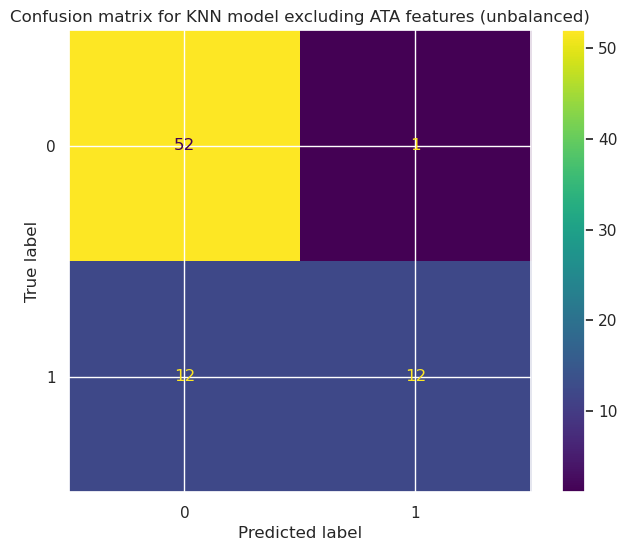

In [76]:
test_res.showConfusionMatrix('Confusion matrix for KNN model excluding ATA features (unbalanced)')

In [77]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.81      0.98      0.89        53
           1       0.92      0.50      0.65        24

    accuracy                           0.83        77
   macro avg       0.87      0.74      0.77        77
weighted avg       0.85      0.83      0.81        77



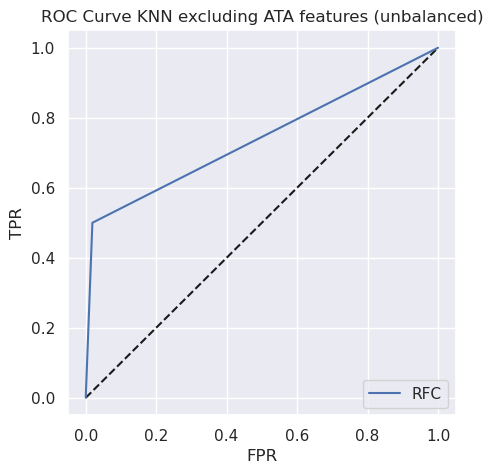

In [78]:
test_res.showRocCurve('ROC Curve KNN excluding ATA features (unbalanced)')

### Excluding ATA Features (Balanced)

In [79]:
ma = ModelAnalysis(ds.getNoAtaBalanced())
val_res, test_res = ma.KNN()

In [80]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.8,0.942308,0.869565,0.907407,0.871154,0.896104,0.833333


In [81]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.666667,0.892857,0.7,0.877193,0.779762,0.831169,0.682927


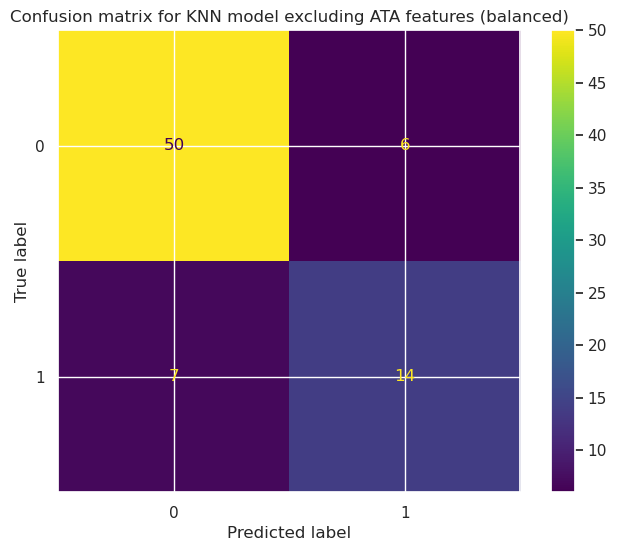

In [82]:
test_res.showConfusionMatrix('Confusion matrix for KNN model excluding ATA features (balanced)')

In [83]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.88      0.89      0.88        56
           1       0.70      0.67      0.68        21

    accuracy                           0.83        77
   macro avg       0.79      0.78      0.78        77
weighted avg       0.83      0.83      0.83        77



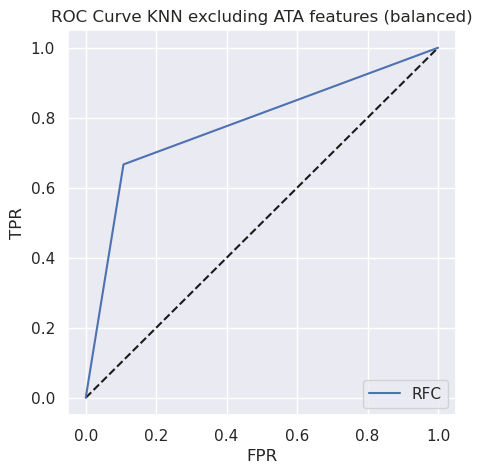

In [84]:
test_res.showRocCurve('ROC Curve KNN excluding ATA features (balanced)')

## Decision Tree

### All Features (Unbalanced)

In [85]:
ma = ModelAnalysis(ds.getAllUnbalanced())
val_res, test_res = ma.DecisionTree()

In [86]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.761905,0.964286,0.888889,0.915254,0.863095,0.909091,0.820513


In [87]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.809524,0.964286,0.894737,0.931034,0.886905,0.922078,0.85


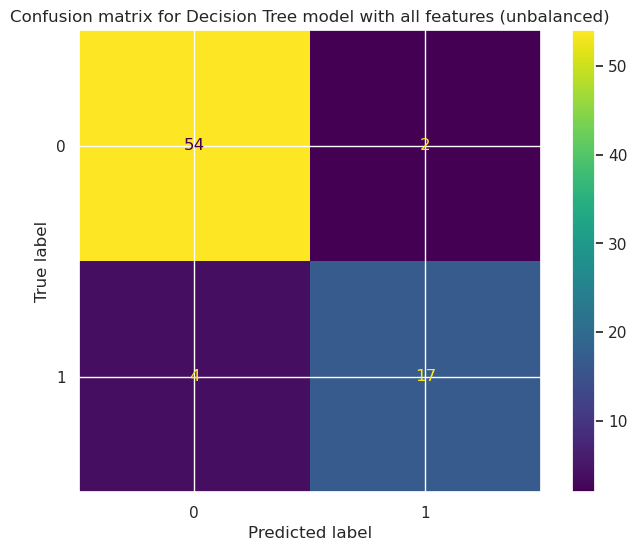

In [88]:
test_res.showConfusionMatrix('Confusion matrix for Decision Tree model with all features (unbalanced)')

In [89]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        56
           1       0.89      0.81      0.85        21

    accuracy                           0.92        77
   macro avg       0.91      0.89      0.90        77
weighted avg       0.92      0.92      0.92        77



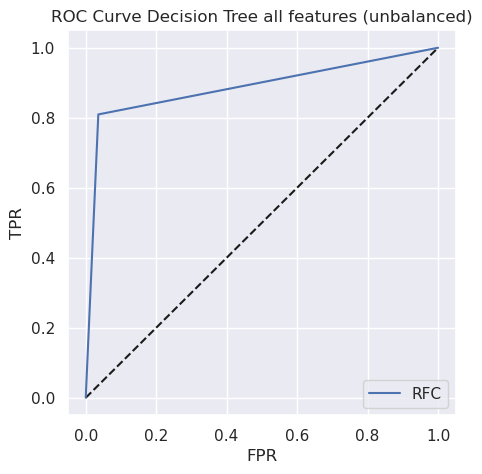

In [90]:
test_res.showRocCurve('ROC Curve Decision Tree all features (unbalanced)')

### All Features (Balanced)

In [91]:
ma = ModelAnalysis(ds.getAllBalanced())
val_res, test_res = ma.DecisionTree()

In [92]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.916667,1.0,1.0,0.963636,0.958333,0.974026,0.956522


In [93]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.875,0.981132,0.954545,0.945455,0.928066,0.948052,0.913043


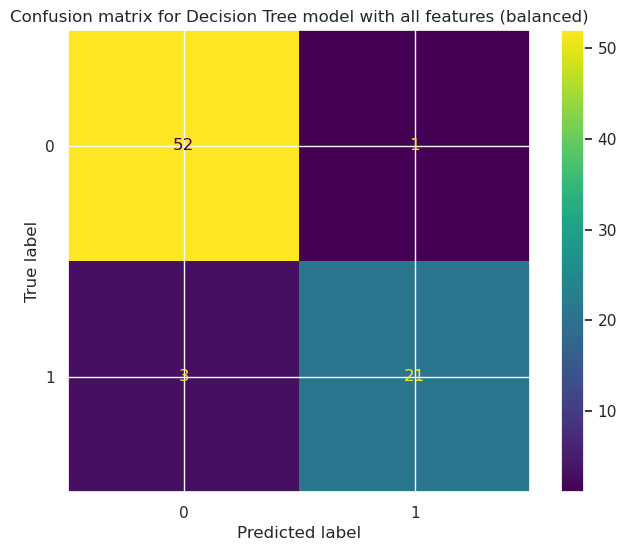

In [94]:
test_res.showConfusionMatrix('Confusion matrix for Decision Tree model with all features (balanced)')

In [95]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        53
           1       0.95      0.88      0.91        24

    accuracy                           0.95        77
   macro avg       0.95      0.93      0.94        77
weighted avg       0.95      0.95      0.95        77



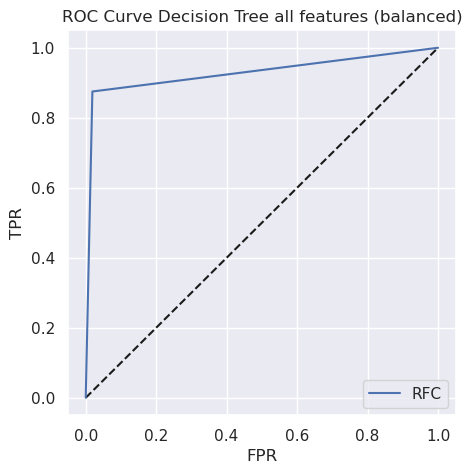

In [96]:
test_res.showRocCurve('ROC Curve Decision Tree all features (balanced)')

### ATA Features (Unbalanced)

In [97]:
ma = ModelAnalysis(ds.getAtaUnbalanced())
val_res, test_res = ma.DecisionTree()

In [98]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.944444,0.830508,0.62963,0.98,0.887476,0.857143,0.755556


In [99]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.875,0.885246,0.666667,0.964286,0.880123,0.883117,0.756757


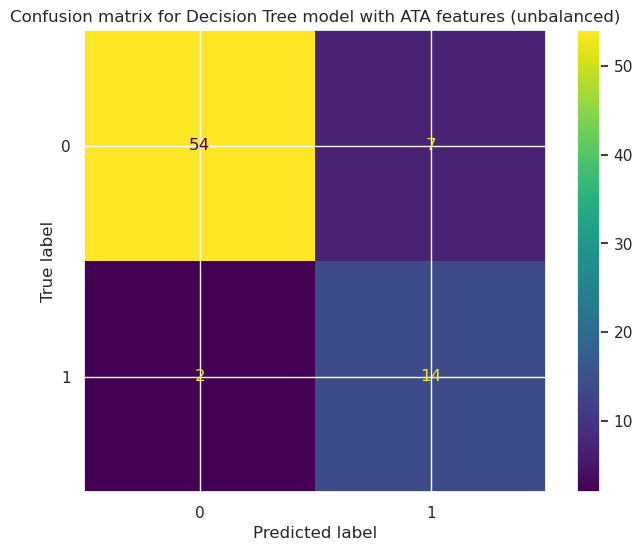

In [100]:
test_res.showConfusionMatrix('Confusion matrix for Decision Tree model with ATA features (unbalanced)')

In [101]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.96      0.89      0.92        61
           1       0.67      0.88      0.76        16

    accuracy                           0.88        77
   macro avg       0.82      0.88      0.84        77
weighted avg       0.90      0.88      0.89        77



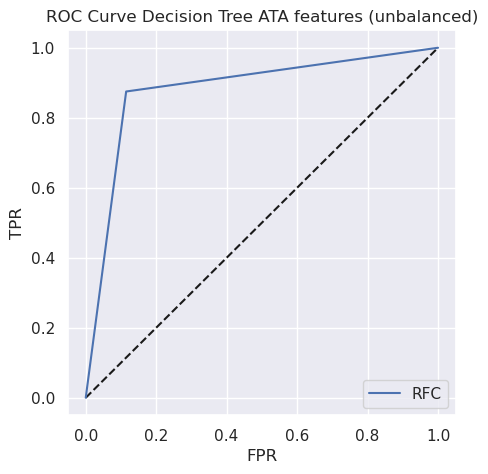

In [102]:
test_res.showRocCurve('ROC Curve Decision Tree ATA features (unbalanced)')

### ATA Features (Balanced)

In [103]:
ma = ModelAnalysis(ds.getAtaBalanced())
val_res, test_res = ma.DecisionTree()

In [104]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.8,0.884615,0.769231,0.901961,0.842308,0.857143,0.784314


In [105]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.954545,0.8,0.65625,0.977778,0.877273,0.844156,0.777778


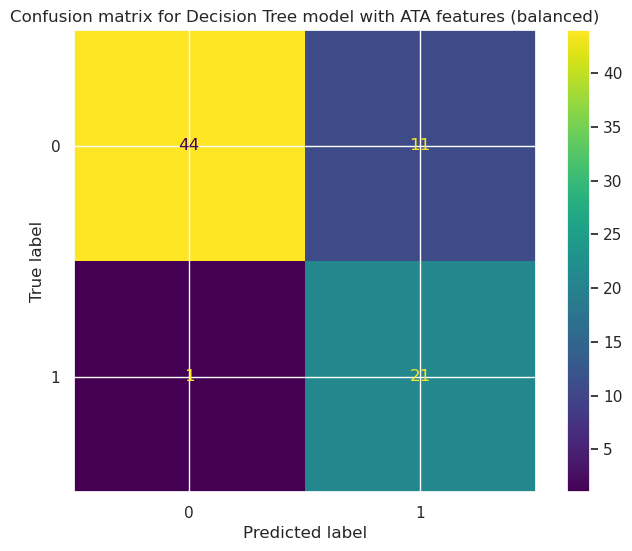

In [106]:
test_res.showConfusionMatrix('Confusion matrix for Decision Tree model with ATA features (balanced)')

In [107]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.98      0.80      0.88        55
           1       0.66      0.95      0.78        22

    accuracy                           0.84        77
   macro avg       0.82      0.88      0.83        77
weighted avg       0.89      0.84      0.85        77



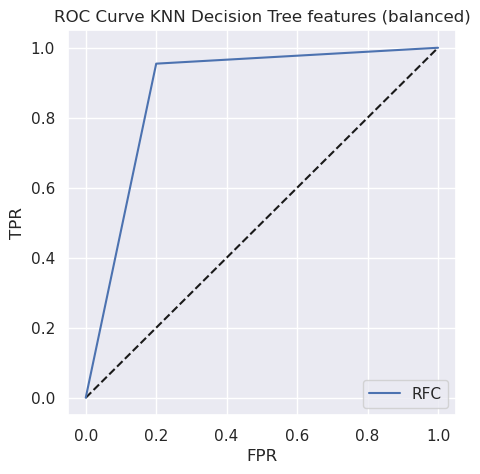

In [108]:
test_res.showRocCurve('ROC Curve KNN Decision Tree features (balanced)')

### Excluding ATA Features (Unbalanced)

In [109]:
ma = ModelAnalysis(ds.getNoAtaUnbalanced())
val_res, test_res = ma.DecisionTree()

In [110]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.842105,0.931034,0.8,0.947368,0.88657,0.909091,0.820513


In [111]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.958333,0.962264,0.92,0.980769,0.960299,0.961039,0.938776


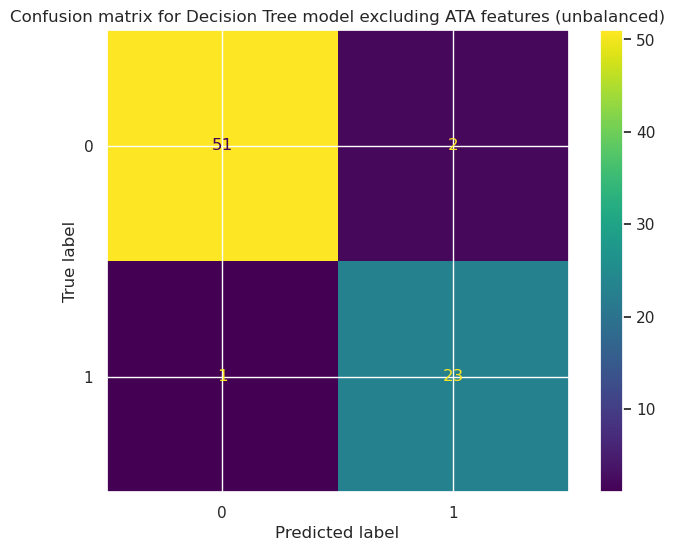

In [112]:
test_res.showConfusionMatrix('Confusion matrix for Decision Tree model excluding ATA features (unbalanced)')

In [113]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        53
           1       0.92      0.96      0.94        24

    accuracy                           0.96        77
   macro avg       0.95      0.96      0.96        77
weighted avg       0.96      0.96      0.96        77



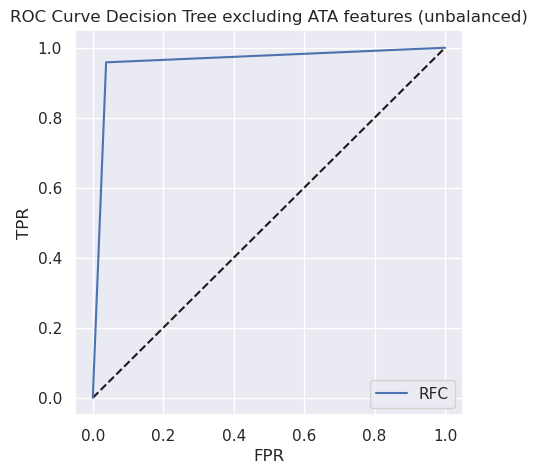

In [114]:
test_res.showRocCurve('ROC Curve Decision Tree excluding ATA features (unbalanced)')

### Excluding ATA Features (Balanced)

In [115]:
ma = ModelAnalysis(ds.getNoAtaBalanced())
val_res, test_res = ma.DecisionTree()

In [116]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.92,0.942308,0.884615,0.960784,0.931154,0.935065,0.901961


In [117]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.809524,0.964286,0.894737,0.931034,0.886905,0.922078,0.85


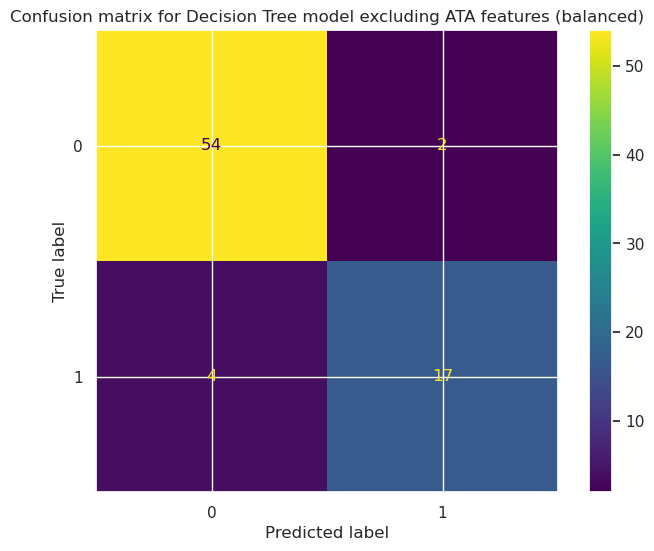

In [118]:
test_res.showConfusionMatrix('Confusion matrix for Decision Tree model excluding ATA features (balanced)')

In [119]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        56
           1       0.89      0.81      0.85        21

    accuracy                           0.92        77
   macro avg       0.91      0.89      0.90        77
weighted avg       0.92      0.92      0.92        77



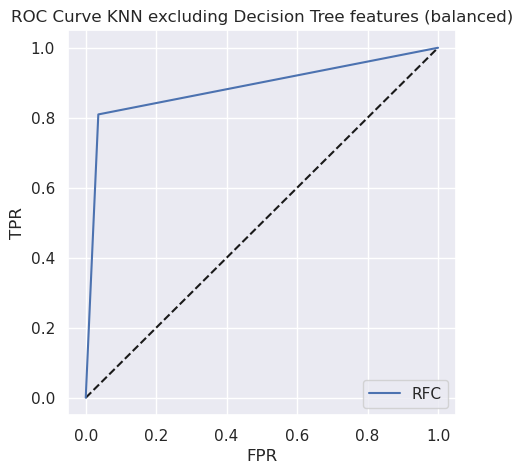

In [120]:
test_res.showRocCurve('ROC Curve KNN excluding Decision Tree features (balanced)')

## SVM

### All Features (Unbalanced)

In [121]:
ma = ModelAnalysis(ds.getAllUnbalanced())
val_res, test_res = ma.SVM()

In [122]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.904762,1.0,1.0,0.965517,0.952381,0.974026,0.95


In [123]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.904762,0.946429,0.863636,0.963636,0.925595,0.935065,0.883721


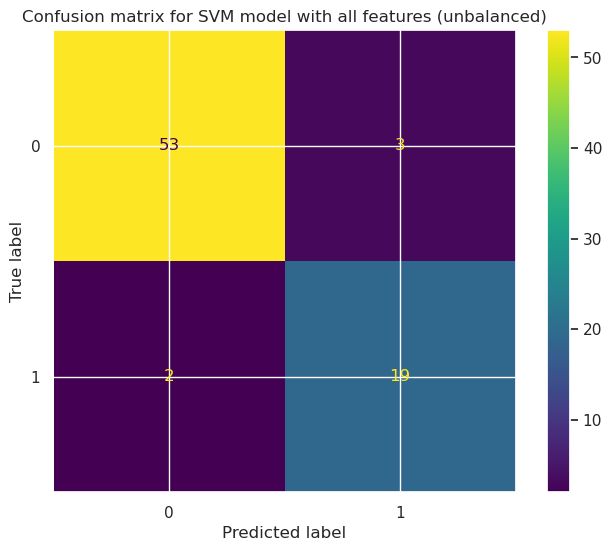

In [124]:
test_res.showConfusionMatrix('Confusion matrix for SVM model with all features (unbalanced)')

In [125]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.96      0.95      0.95        56
           1       0.86      0.90      0.88        21

    accuracy                           0.94        77
   macro avg       0.91      0.93      0.92        77
weighted avg       0.94      0.94      0.94        77



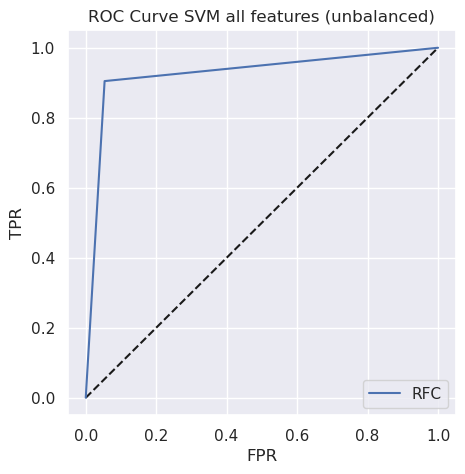

In [126]:
test_res.showRocCurve('ROC Curve SVM all features (unbalanced)')

### All Features (Balanced)

In [127]:
ma = ModelAnalysis(ds.getAllBalanced())
val_res, test_res = ma.SVM()

In [128]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.833333,0.943396,0.869565,0.925926,0.888365,0.909091,0.851064


In [129]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.791667,0.924528,0.826087,0.907407,0.858097,0.883117,0.808511


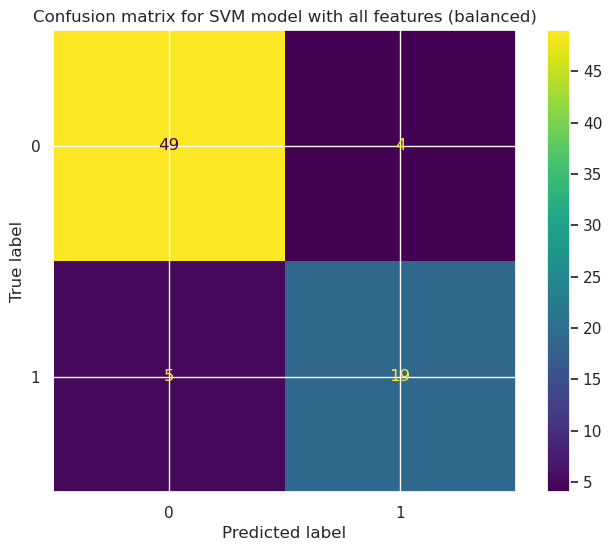

In [130]:
test_res.showConfusionMatrix('Confusion matrix for SVM model with all features (balanced)')

In [131]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.91      0.92      0.92        53
           1       0.83      0.79      0.81        24

    accuracy                           0.88        77
   macro avg       0.87      0.86      0.86        77
weighted avg       0.88      0.88      0.88        77



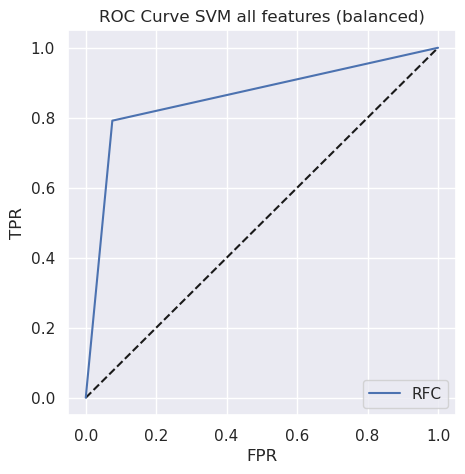

In [132]:
test_res.showRocCurve('ROC Curve SVM all features (balanced)')

### ATA Features (Unbalanced)

In [133]:
ma = ModelAnalysis(ds.getAtaUnbalanced())
val_res, test_res = ma.SVM()

In [134]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.944444,0.830508,0.62963,0.98,0.887476,0.857143,0.755556


In [135]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.875,0.885246,0.666667,0.964286,0.880123,0.883117,0.756757


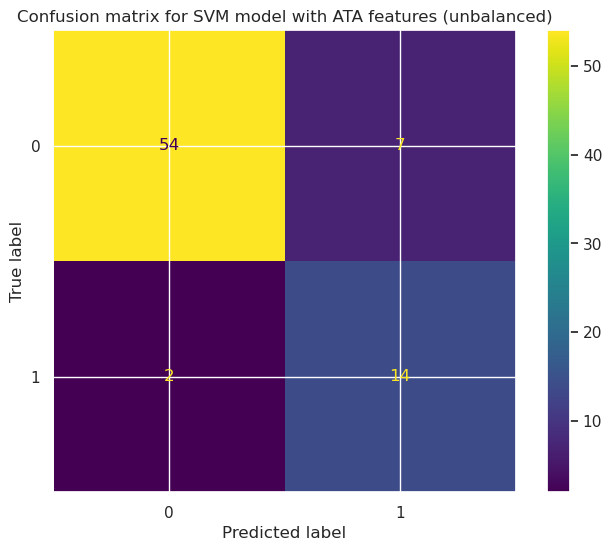

In [136]:
test_res.showConfusionMatrix('Confusion matrix for SVM model with ATA features (unbalanced)')

In [137]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.96      0.89      0.92        61
           1       0.67      0.88      0.76        16

    accuracy                           0.88        77
   macro avg       0.82      0.88      0.84        77
weighted avg       0.90      0.88      0.89        77



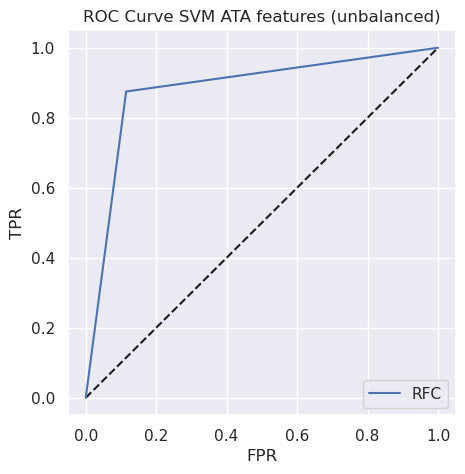

In [138]:
test_res.showRocCurve('ROC Curve SVM ATA features (unbalanced)')

### ATA Features (Balanced)

In [139]:
ma = ModelAnalysis(ds.getAtaBalanced())
val_res, test_res = ma.SVM()

In [140]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.8,0.884615,0.769231,0.901961,0.842308,0.857143,0.784314


In [141]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.954545,0.8,0.65625,0.977778,0.877273,0.844156,0.777778


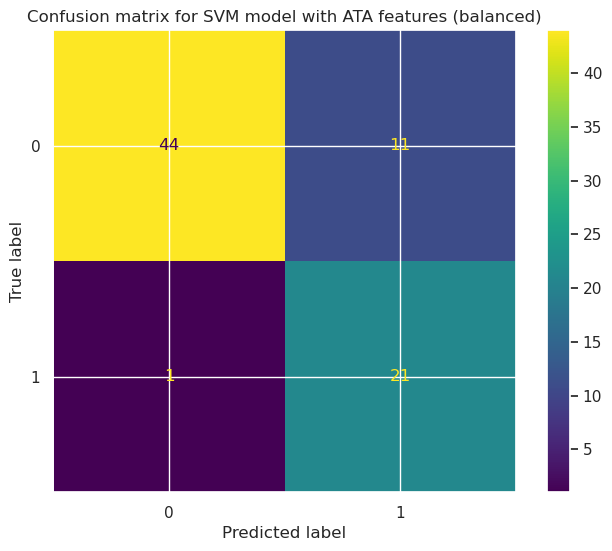

In [142]:
test_res.showConfusionMatrix('Confusion matrix for SVM model with ATA features (balanced)')

In [143]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.98      0.80      0.88        55
           1       0.66      0.95      0.78        22

    accuracy                           0.84        77
   macro avg       0.82      0.88      0.83        77
weighted avg       0.89      0.84      0.85        77



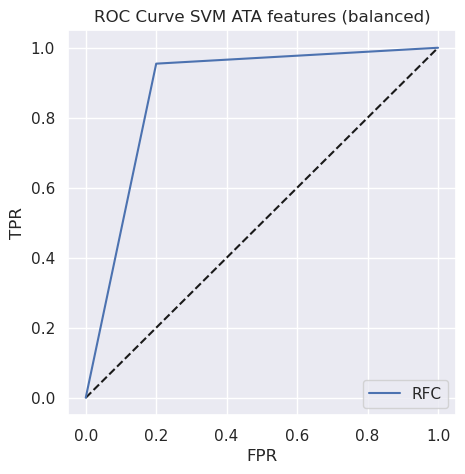

In [144]:
test_res.showRocCurve('ROC Curve SVM ATA features (balanced)')

### Excluding ATA Features (Unbalanced)

In [145]:
ma = ModelAnalysis(ds.getNoAtaUnbalanced())
val_res, test_res = ma.SVM()

In [146]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.842105,0.913793,0.761905,0.946429,0.877949,0.896104,0.8


In [147]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.875,0.981132,0.954545,0.945455,0.928066,0.948052,0.913043


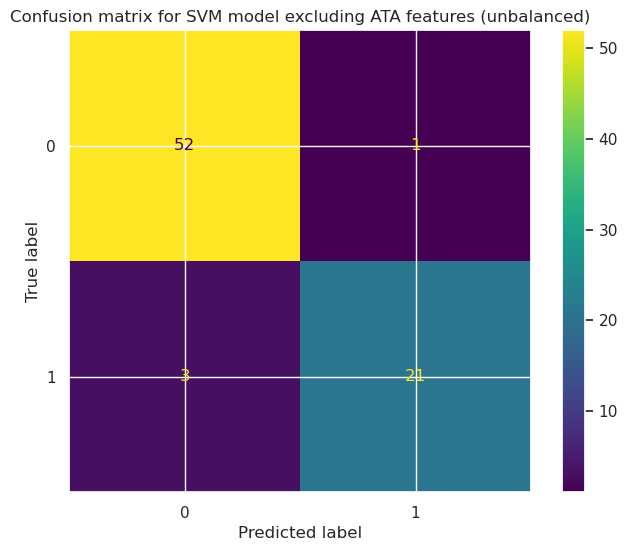

In [148]:
test_res.showConfusionMatrix('Confusion matrix for SVM model excluding ATA features (unbalanced)')

In [149]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        53
           1       0.95      0.88      0.91        24

    accuracy                           0.95        77
   macro avg       0.95      0.93      0.94        77
weighted avg       0.95      0.95      0.95        77



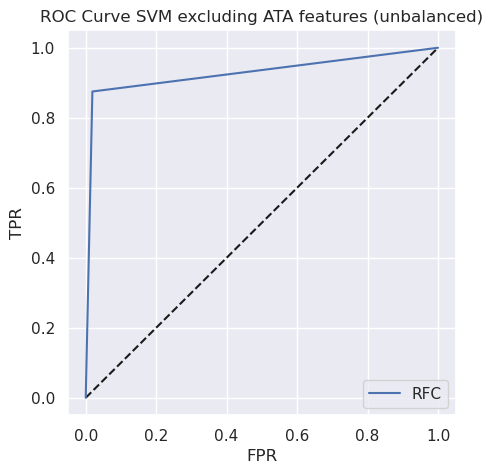

In [150]:
test_res.showRocCurve('ROC Curve SVM excluding ATA features (unbalanced)')

### Excluding ATA Features (Balanced)

In [151]:
ma = ModelAnalysis(ds.getNoAtaBalanced())
val_res, test_res = ma.SVM()

In [152]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.96,0.942308,0.888889,0.98,0.951154,0.948052,0.923077


In [153]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.714286,0.857143,0.652174,0.888889,0.785714,0.818182,0.681818


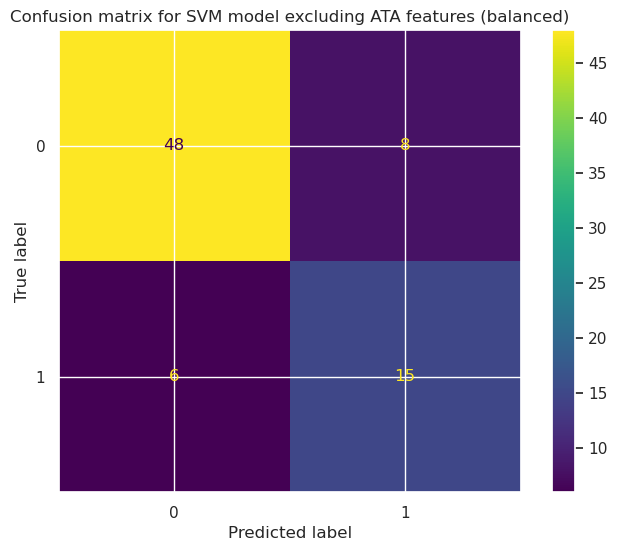

In [154]:
test_res.showConfusionMatrix('Confusion matrix for SVM model excluding ATA features (balanced)')

In [155]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.89      0.86      0.87        56
           1       0.65      0.71      0.68        21

    accuracy                           0.82        77
   macro avg       0.77      0.79      0.78        77
weighted avg       0.82      0.82      0.82        77



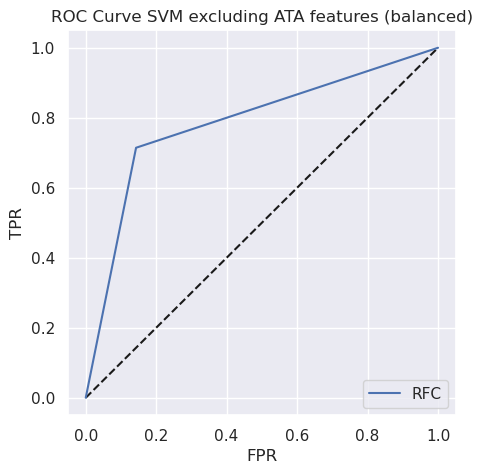

In [156]:
test_res.showRocCurve('ROC Curve SVM excluding ATA features (balanced)')

## LightGBM

### All Features (Unbalanced)

In [157]:
ma = ModelAnalysis(ds.getAllUnbalanced())
val_res, test_res = ma.LightGBM()

In [158]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.904762,0.982143,0.95,0.964912,0.943452,0.961039,0.926829


In [159]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,1.0,0.964286,0.913043,1.0,0.982143,0.974026,0.954545


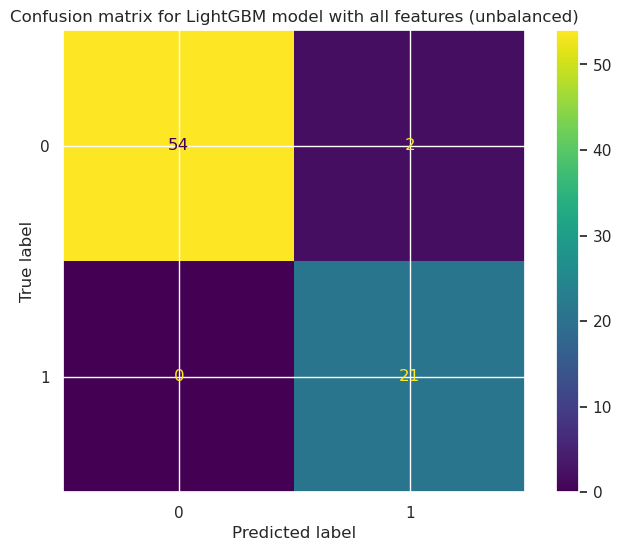

In [160]:
test_res.showConfusionMatrix('Confusion matrix for LightGBM model with all features (unbalanced)')

In [161]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        56
           1       0.91      1.00      0.95        21

    accuracy                           0.97        77
   macro avg       0.96      0.98      0.97        77
weighted avg       0.98      0.97      0.97        77



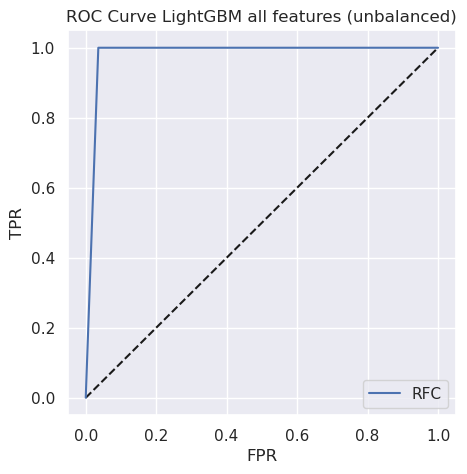

In [162]:
test_res.showRocCurve('ROC Curve LightGBM all features (unbalanced)')

### All Features (Balanced)

In [163]:
ma = ModelAnalysis(ds.getAllBalanced())
val_res, test_res = ma.LightGBM()

In [164]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.916667,0.981132,0.956522,0.962963,0.948899,0.961039,0.93617


In [165]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.958333,1.0,1.0,0.981481,0.979167,0.987013,0.978723


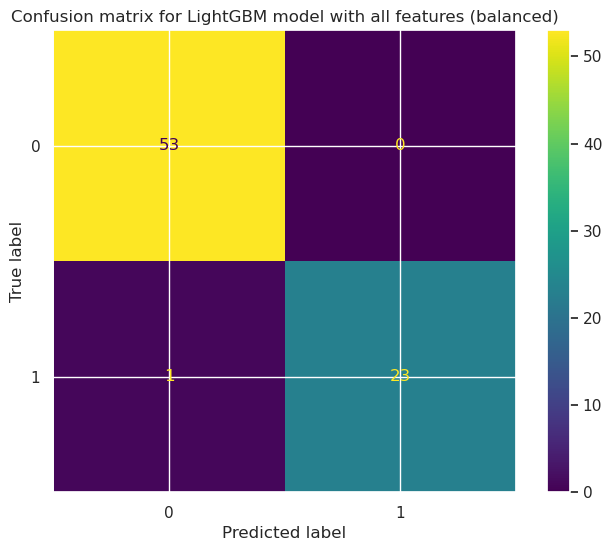

In [166]:
test_res.showConfusionMatrix('Confusion matrix for LightGBM model with all features (balanced)')

In [167]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       1.00      0.96      0.98        24

    accuracy                           0.99        77
   macro avg       0.99      0.98      0.98        77
weighted avg       0.99      0.99      0.99        77



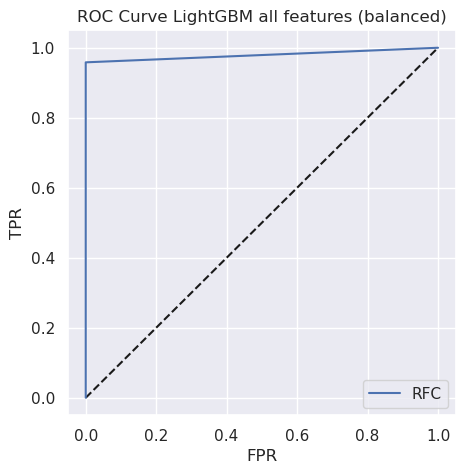

In [168]:
test_res.showRocCurve('ROC Curve LightGBM all features (balanced)')

### ATA Features (Unbalanced)

In [169]:
ma = ModelAnalysis(ds.getAtaUnbalanced())
val_res, test_res = ma.LightGBM()

In [170]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.944444,0.830508,0.62963,0.98,0.887476,0.857143,0.755556


In [171]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.875,0.885246,0.666667,0.964286,0.880123,0.883117,0.756757


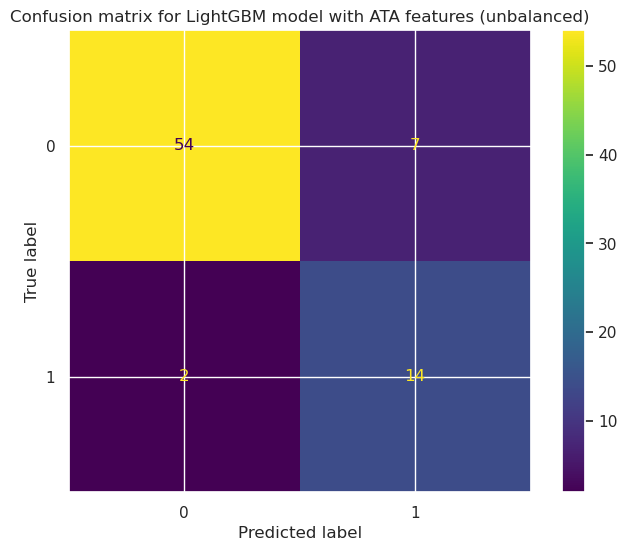

In [172]:
test_res.showConfusionMatrix('Confusion matrix for LightGBM model with ATA features (unbalanced)')

In [173]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.96      0.89      0.92        61
           1       0.67      0.88      0.76        16

    accuracy                           0.88        77
   macro avg       0.82      0.88      0.84        77
weighted avg       0.90      0.88      0.89        77



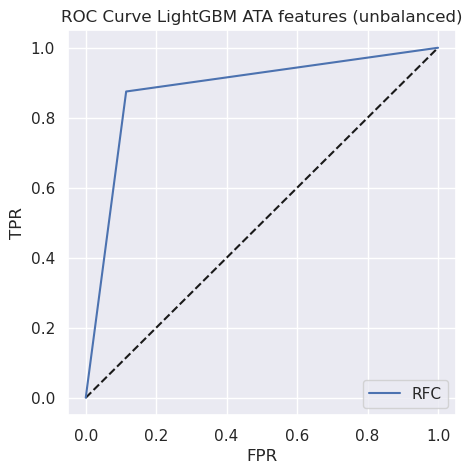

In [174]:
test_res.showRocCurve('ROC Curve LightGBM ATA features (unbalanced)')

### ATA Features (Balanced)

In [175]:
ma = ModelAnalysis(ds.getAtaBalanced())
val_res, test_res = ma.LightGBM()

In [176]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.8,0.884615,0.769231,0.901961,0.842308,0.857143,0.784314


In [177]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.954545,0.8,0.65625,0.977778,0.877273,0.844156,0.777778


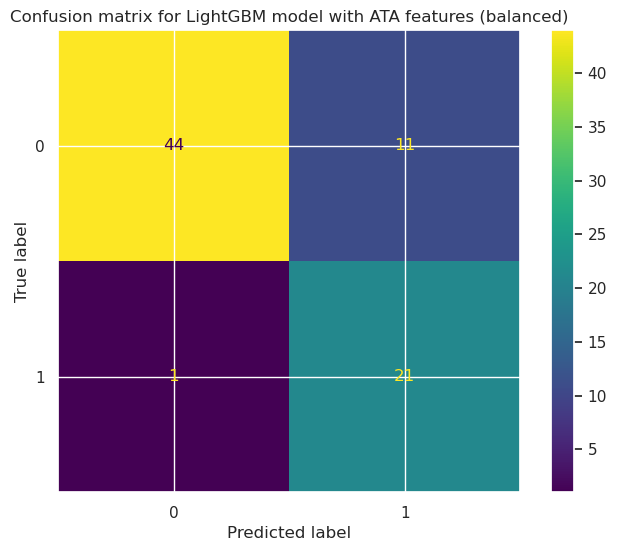

In [178]:
test_res.showConfusionMatrix('Confusion matrix for LightGBM model with ATA features (balanced)')

In [179]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.98      0.80      0.88        55
           1       0.66      0.95      0.78        22

    accuracy                           0.84        77
   macro avg       0.82      0.88      0.83        77
weighted avg       0.89      0.84      0.85        77



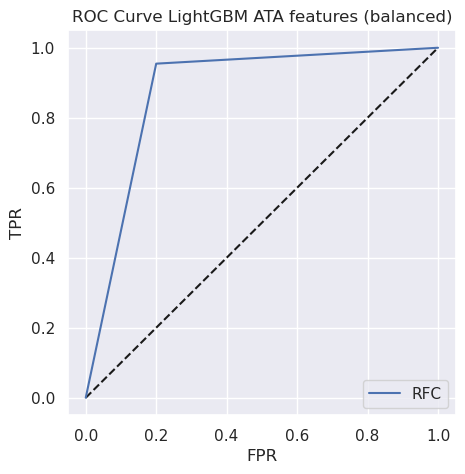

In [180]:
test_res.showRocCurve('ROC Curve LightGBM ATA features (balanced)')

### Excluding ATA Features (Unbalanced)

In [181]:
ma = ModelAnalysis(ds.getNoAtaUnbalanced())
val_res, test_res = ma.LightGBM()

In [182]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.894737,0.965517,0.894737,0.965517,0.930127,0.948052,0.894737


In [183]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.958333,0.962264,0.92,0.980769,0.960299,0.961039,0.938776


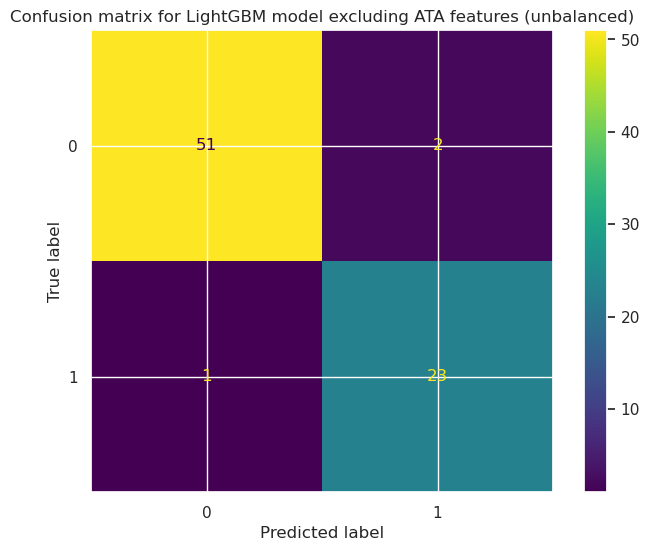

In [184]:
test_res.showConfusionMatrix('Confusion matrix for LightGBM model excluding ATA features (unbalanced)')

In [185]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        53
           1       0.92      0.96      0.94        24

    accuracy                           0.96        77
   macro avg       0.95      0.96      0.96        77
weighted avg       0.96      0.96      0.96        77



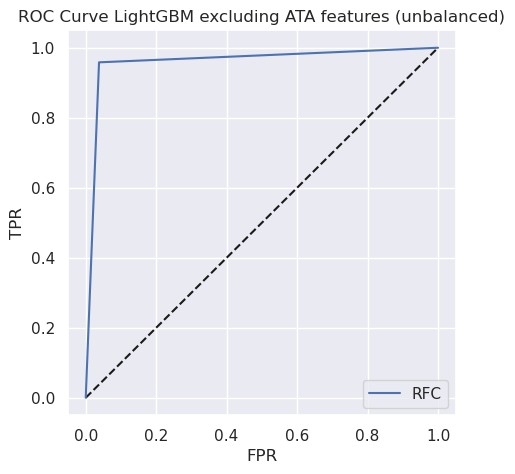

In [186]:
test_res.showRocCurve('ROC Curve LightGBM excluding ATA features (unbalanced)')

### Excluding ATA Features (Balanced)

In [187]:
ma = ModelAnalysis(ds.getNoAtaBalanced())
val_res, test_res = ma.LightGBM()

In [188]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.96,0.980769,0.96,0.980769,0.970385,0.974026,0.96


In [189]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.809524,0.928571,0.809524,0.928571,0.869048,0.896104,0.809524


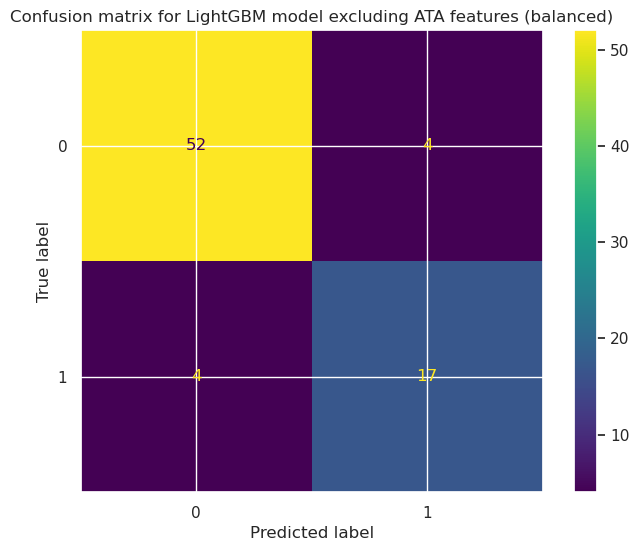

In [190]:
test_res.showConfusionMatrix('Confusion matrix for LightGBM model excluding ATA features (balanced)')

In [191]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        56
           1       0.81      0.81      0.81        21

    accuracy                           0.90        77
   macro avg       0.87      0.87      0.87        77
weighted avg       0.90      0.90      0.90        77



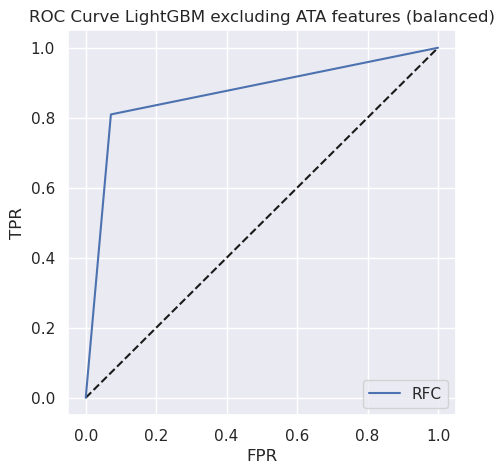

In [192]:
test_res.showRocCurve('ROC Curve LightGBM excluding ATA features (balanced)')

## ANN

### All Features (Unbalanced)

In [194]:
ma = ModelAnalysis(ds.getAllUnbalanced())
val_res, test_res = ma.ANN("./BestAnnModel.keras")

3/3 [==============================] - 0s 3ms/step


In [195]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.857143,1.0,1.0,0.949153,0.928571,0.961039,0.923077


In [196]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.809524,0.928571,0.809524,0.928571,0.869048,0.896104,0.809524


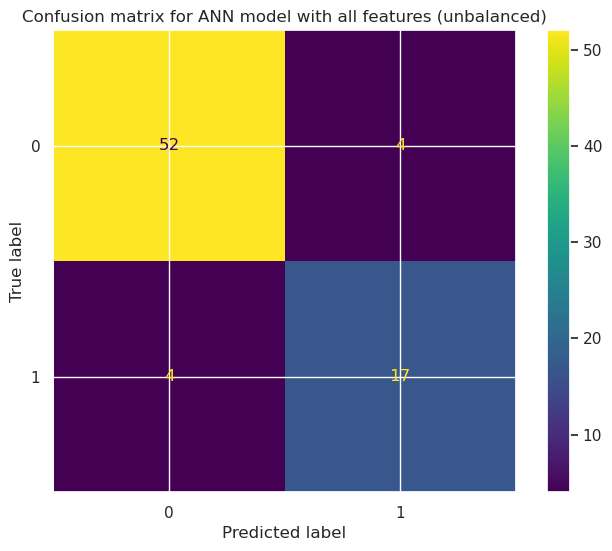

In [197]:
test_res.showConfusionMatrix('Confusion matrix for ANN model with all features (unbalanced)')

In [198]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        56
           1       0.81      0.81      0.81        21

    accuracy                           0.90        77
   macro avg       0.87      0.87      0.87        77
weighted avg       0.90      0.90      0.90        77



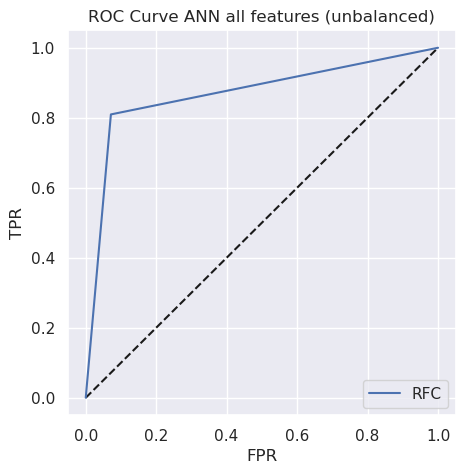

In [199]:
test_res.showRocCurve('ROC Curve ANN all features (unbalanced)')

### All Features (Balanced)

In [200]:
ma = ModelAnalysis(ds.getAllBalanced())
val_res, test_res = ma.ANN("./BestAnnModelBalanced.keras")

3/3 [==============================] - 0s 3ms/step


In [201]:
print("Validation Results:")
val_res.showResults()

Validation Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.833333,0.924528,0.833333,0.924528,0.878931,0.896104,0.833333


In [202]:
print("Test Results:")
test_res.showResults()

Test Results:


,Sensitivity,Specificity,PPV,NPV,AUC Score,Accuracy,F1
0,0.916667,0.943396,0.88,0.961538,0.930031,0.935065,0.897959


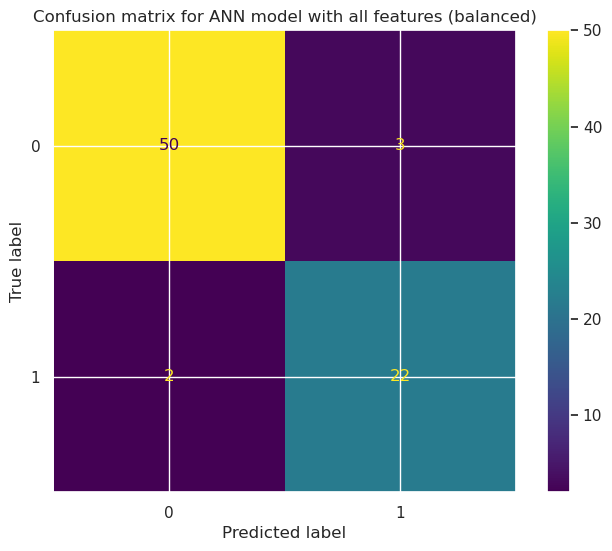

In [203]:
test_res.showConfusionMatrix('Confusion matrix for ANN model with all features (balanced)')

In [204]:
test_res.showClassificationReport()

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        53
           1       0.88      0.92      0.90        24

    accuracy                           0.94        77
   macro avg       0.92      0.93      0.93        77
weighted avg       0.94      0.94      0.94        77



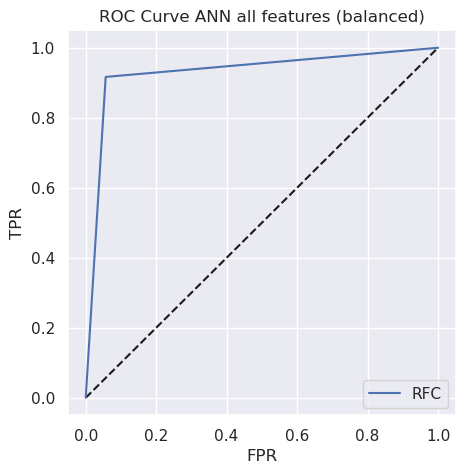

In [205]:
test_res.showRocCurve('ROC Curve ANN all features (balanced)')